<a href="https://colab.research.google.com/github/red-haired13/flower/blob/main/flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU 
from keras.layers.convolutional import UpSampling2D, Conv2D 
from keras.models import Sequential, Model 
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/Базы/ALL.zip'

In [ ]:
images = 'ALL'
img_rows = 256
img_cols = 256
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
batch_size = 128

optimizer = Adam(0.0002, 0.5)

In [ ]:
def load_images(images, img_rows, img_cols): 
  list_images = []
  for img in os.listdir(images):
  
    list_images.append(image.img_to_array(image.load_img(os.path.join(images, img), target_size=(img_rows, img_cols), color_mode='grayscale')))
  return np.array(list_images)

In [ ]:
!mkdir images

In [ ]:
def create_generator():
  generator = Sequential()

  generator.add(Dense(256, input_dim=latent_dim))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(512))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Dense(np.prod(img_shape), activation='tanh'))
  generator.add(Reshape(img_shape))

  noise = Input(shape=(latent_dim,))
  img = generator(noise)

  generator = Model(noise, img)

  return generator

In [ ]:
gen = create_generator()
gen.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 1)       68913920  
Total params: 68,913,920
Trainable params: 68,910,336
Non-trainable params: 3,584
_________________________________________________________________


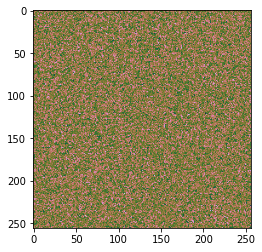

In [ ]:
input1 = np.random.random(size=(1, 100))
plt.imshow(input1, cmap='cubehelix')
plt.axis('off')
plt.show()
predict_gen = gen.predict(input1)
plt.imshow(predict_gen[0].reshape(256, 256), cmap='cubehelix')
plt.show()

In [ ]:
def create_conv_discriminator(): # Функция создания сверточного дискрминатора
  currDisc = Sequential()  # Инициализируем модель currDisc

  currDisc.add(Conv2D(4, (3,3), padding="same", input_shape=img_shape)) # Создаем слой  Conv2D (размерность входных данных (img_shape), ядро свертки = 2, окно свертки = (3,3))
  currDisc.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  currDisc.add(Flatten()) # Добавляем слой Flatten ()
  currDisc.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
  currDisc.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  currDisc.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

  img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  validity = currDisc(img) # Записываем в переменную validity значение, возвращаемое currDisc'ом с входным параметром img

  discriminator_conv = Model(img, validity) # Создаем модель discriminator_conv (входные данные: img, выходные данные: validity)

  # Компилируем модель дискриманотра
  discriminator_conv.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
 
  discriminator_conv.trainable = False  # Замораживаем обучение дискриматора 
 
  return discriminator_conv # Функция возвращает discriminator_conv  

In [ ]:
dis = create_conv_discriminator()
dis.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 134218793 
Total params: 134,218,793
Trainable params: 0
Non-trainable params: 134,218,793
_________________________________________________________________


In [ ]:
predict_dis = dis.predict(predict_gen)
print(predict_dis)

[[0.4998047]]


In [ ]:
batch_size = 128
X_Train_imag = load_images(images, img_rows, img_cols)
X_Train = X_Train_imag / 127.5 - 1

In [ ]:
def sample_images(epoch, gen): # Функция печати изображений
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, latent_dim)) 
  gen_imgs = gen.predict(noise)
  

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r): 
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='cubehelix')
          axs[i,j].axis('off')
          cnt += 1
  plt.show()
  fig.savefig("images/%d.png" % epoch)
  plt.close()

In [ ]:
def train(generator, discriminator, epochs=30000, batch_size=128):
  
  valid = np.ones((batch_size, 1)) 
  fake = np.zeros((batch_size, 1)) 

  z = Input(shape=(latent_dim,))
  img = generator(z)
  validity = discriminator(img)

  combined = Model(z, validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  sample_interval = 200
  
  d_loss_list = []
  g_loss_list = []
  d_acc_list = []
  
  for epoch in range(epochs): 

    idx = np.random.randint(0, X_Train.shape[0], batch_size)
    imgs = X_Train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    
    gen_imgs = generator.predict(noise)
      
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    g_loss = combined.train_on_batch(noise, valid)
    
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss)
    d_acc_list.append(100*d_loss[1])
        
    
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)): 
        sample_images(epoch, generator)
  
  
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()

0 [D loss: 9.956608, acc.: 10.94%] [G loss: 0.156468]


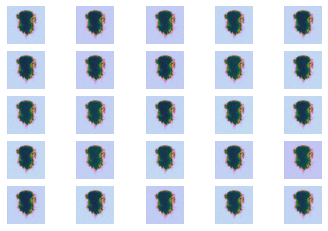

1 [D loss: 306.820870, acc.: 49.22%] [G loss: 0.000000]
2 [D loss: 139.085354, acc.: 49.61%] [G loss: 129.477417]
3 [D loss: 2.011814, acc.: 76.17%] [G loss: 350.700989]
4 [D loss: 125.401351, acc.: 39.06%] [G loss: 56.835701]
5 [D loss: 82.989740, acc.: 30.47%] [G loss: 77.255089]
6 [D loss: 35.225471, acc.: 54.30%] [G loss: 729.236694]
7 [D loss: 12.130415, acc.: 83.98%] [G loss: 941.237366]
8 [D loss: 56.348835, acc.: 85.55%] [G loss: 632.221802]
9 [D loss: 42.546749, acc.: 83.59%] [G loss: 255.623566]
10 [D loss: 51.794927, acc.: 80.47%] [G loss: 266.249908]
11 [D loss: 13.872020, acc.: 86.72%] [G loss: 273.781738]
12 [D loss: 6.082067, acc.: 86.72%] [G loss: 223.858765]
13 [D loss: 0.590086, acc.: 94.92%] [G loss: 206.113510]
14 [D loss: 1.640117, acc.: 89.84%] [G loss: 209.665863]
15 [D loss: 0.736718, acc.: 92.97%] [G loss: 197.367828]
16 [D loss: 1.703427, acc.: 92.58%] [G loss: 163.033585]
17 [D loss: 5.328793, acc.: 78.91%] [G loss: 277.056427]
18 [D loss: 4.157772, acc.: 73.

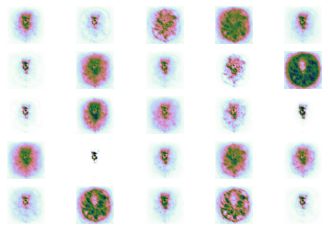

201 [D loss: 3.170035, acc.: 37.89%] [G loss: 4.280980]
202 [D loss: 3.282374, acc.: 20.31%] [G loss: 8.909550]
203 [D loss: 3.040065, acc.: 56.25%] [G loss: 4.451332]
204 [D loss: 3.408988, acc.: 24.22%] [G loss: 7.264453]
205 [D loss: 2.621343, acc.: 49.61%] [G loss: 4.900617]
206 [D loss: 3.381961, acc.: 20.70%] [G loss: 7.737184]
207 [D loss: 2.774083, acc.: 50.78%] [G loss: 4.902137]
208 [D loss: 3.531495, acc.: 23.83%] [G loss: 5.335080]
209 [D loss: 2.170853, acc.: 46.48%] [G loss: 4.971546]
210 [D loss: 2.977941, acc.: 30.86%] [G loss: 5.614237]
211 [D loss: 2.696046, acc.: 37.89%] [G loss: 4.836852]
212 [D loss: 2.314641, acc.: 40.23%] [G loss: 6.049399]
213 [D loss: 2.284848, acc.: 54.69%] [G loss: 3.031838]
214 [D loss: 2.855708, acc.: 26.17%] [G loss: 7.581929]
215 [D loss: 2.393234, acc.: 59.77%] [G loss: 3.307708]
216 [D loss: 3.526715, acc.: 26.17%] [G loss: 4.866080]
217 [D loss: 2.341083, acc.: 47.66%] [G loss: 3.759818]
218 [D loss: 2.711794, acc.: 23.05%] [G loss: 7.

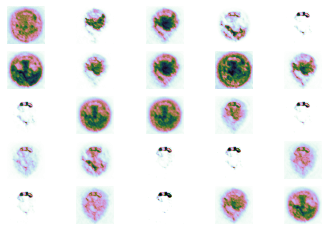

401 [D loss: 1.360146, acc.: 43.36%] [G loss: 5.651256]
402 [D loss: 1.209432, acc.: 63.67%] [G loss: 3.723985]
403 [D loss: 1.618242, acc.: 31.25%] [G loss: 6.351834]
404 [D loss: 1.399439, acc.: 67.19%] [G loss: 3.528140]
405 [D loss: 1.294217, acc.: 49.61%] [G loss: 5.517993]
406 [D loss: 1.130885, acc.: 64.45%] [G loss: 3.290336]
407 [D loss: 1.433788, acc.: 36.33%] [G loss: 6.869631]
408 [D loss: 1.667293, acc.: 63.67%] [G loss: 3.821512]
409 [D loss: 1.879415, acc.: 28.91%] [G loss: 6.850104]
410 [D loss: 1.380122, acc.: 67.97%] [G loss: 3.983502]
411 [D loss: 2.164427, acc.: 23.05%] [G loss: 5.564387]
412 [D loss: 1.084872, acc.: 68.75%] [G loss: 4.307643]
413 [D loss: 1.329650, acc.: 46.09%] [G loss: 4.789227]
414 [D loss: 1.062650, acc.: 63.67%] [G loss: 4.018857]
415 [D loss: 1.280828, acc.: 48.05%] [G loss: 5.494171]
416 [D loss: 1.185650, acc.: 67.19%] [G loss: 3.196954]
417 [D loss: 1.679151, acc.: 29.69%] [G loss: 6.914135]
418 [D loss: 1.483362, acc.: 65.62%] [G loss: 4.

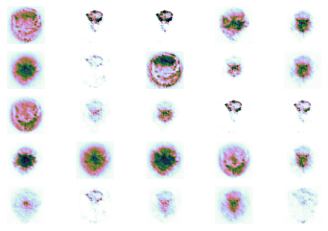

601 [D loss: 0.768040, acc.: 76.17%] [G loss: 2.953503]
602 [D loss: 1.292985, acc.: 33.98%] [G loss: 5.398876]
603 [D loss: 1.198430, acc.: 69.92%] [G loss: 3.582031]
604 [D loss: 1.628168, acc.: 34.77%] [G loss: 4.111959]
605 [D loss: 0.810806, acc.: 73.83%] [G loss: 3.120980]
606 [D loss: 1.244747, acc.: 36.33%] [G loss: 4.703820]
607 [D loss: 1.145623, acc.: 67.97%] [G loss: 2.610640]
608 [D loss: 1.231570, acc.: 42.19%] [G loss: 5.010008]
609 [D loss: 1.203708, acc.: 69.53%] [G loss: 3.022852]
610 [D loss: 1.409251, acc.: 33.20%] [G loss: 5.259920]
611 [D loss: 1.241008, acc.: 67.19%] [G loss: 3.658617]
612 [D loss: 1.700621, acc.: 30.86%] [G loss: 3.857967]
613 [D loss: 0.965300, acc.: 65.23%] [G loss: 3.431181]
614 [D loss: 1.595054, acc.: 27.73%] [G loss: 4.748993]
615 [D loss: 1.152160, acc.: 68.36%] [G loss: 2.901005]
616 [D loss: 1.403516, acc.: 29.30%] [G loss: 5.276201]
617 [D loss: 1.129053, acc.: 70.31%] [G loss: 3.705164]
618 [D loss: 1.569432, acc.: 32.81%] [G loss: 4.

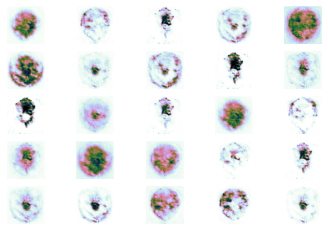

801 [D loss: 0.735216, acc.: 65.62%] [G loss: 3.646712]
802 [D loss: 1.114889, acc.: 48.05%] [G loss: 3.775735]
803 [D loss: 1.023035, acc.: 56.25%] [G loss: 3.623032]
804 [D loss: 0.949727, acc.: 58.20%] [G loss: 3.628730]
805 [D loss: 1.061825, acc.: 47.27%] [G loss: 4.068582]
806 [D loss: 1.112179, acc.: 57.81%] [G loss: 3.285378]
807 [D loss: 1.119107, acc.: 43.75%] [G loss: 4.410971]
808 [D loss: 0.676877, acc.: 73.44%] [G loss: 3.194747]
809 [D loss: 0.953106, acc.: 45.31%] [G loss: 4.207509]
810 [D loss: 0.873925, acc.: 69.14%] [G loss: 3.032419]
811 [D loss: 0.880440, acc.: 44.14%] [G loss: 4.502776]
812 [D loss: 0.981765, acc.: 67.97%] [G loss: 2.994758]
813 [D loss: 0.815253, acc.: 56.25%] [G loss: 3.999240]
814 [D loss: 0.947038, acc.: 65.62%] [G loss: 3.245996]
815 [D loss: 1.001445, acc.: 44.14%] [G loss: 3.905480]
816 [D loss: 0.969084, acc.: 63.28%] [G loss: 3.375849]
817 [D loss: 1.020330, acc.: 51.56%] [G loss: 3.837085]
818 [D loss: 0.823732, acc.: 72.27%] [G loss: 3.

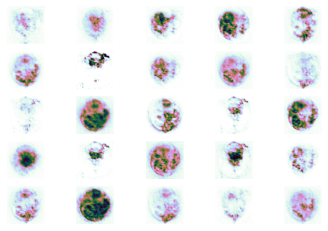

1001 [D loss: 0.943046, acc.: 66.02%] [G loss: 2.976276]
1002 [D loss: 0.945959, acc.: 45.70%] [G loss: 3.868020]
1003 [D loss: 0.819947, acc.: 68.75%] [G loss: 3.131804]
1004 [D loss: 1.003319, acc.: 43.75%] [G loss: 3.890918]
1005 [D loss: 0.739057, acc.: 74.22%] [G loss: 2.866794]
1006 [D loss: 0.995068, acc.: 39.06%] [G loss: 4.410981]
1007 [D loss: 0.881246, acc.: 71.48%] [G loss: 2.909231]
1008 [D loss: 1.134276, acc.: 39.84%] [G loss: 3.908905]
1009 [D loss: 0.705436, acc.: 74.22%] [G loss: 2.991519]
1010 [D loss: 0.965901, acc.: 39.84%] [G loss: 4.360689]
1011 [D loss: 1.043604, acc.: 65.62%] [G loss: 2.776978]
1012 [D loss: 0.802386, acc.: 49.61%] [G loss: 3.944349]
1013 [D loss: 0.783945, acc.: 73.05%] [G loss: 2.960119]
1014 [D loss: 1.187895, acc.: 28.52%] [G loss: 4.274465]
1015 [D loss: 0.745167, acc.: 76.56%] [G loss: 3.147759]
1016 [D loss: 1.232286, acc.: 30.86%] [G loss: 4.171036]
1017 [D loss: 0.771507, acc.: 74.22%] [G loss: 3.001020]
1018 [D loss: 1.186910, acc.: 3

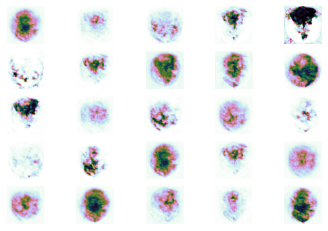

1201 [D loss: 0.858349, acc.: 71.09%] [G loss: 3.065390]
1202 [D loss: 1.089998, acc.: 41.41%] [G loss: 3.674184]
1203 [D loss: 1.077891, acc.: 55.47%] [G loss: 3.365386]
1204 [D loss: 0.888598, acc.: 58.59%] [G loss: 3.564500]
1205 [D loss: 0.947847, acc.: 64.06%] [G loss: 3.059564]
1206 [D loss: 0.831646, acc.: 67.19%] [G loss: 3.489685]
1207 [D loss: 0.969126, acc.: 58.59%] [G loss: 3.308350]
1208 [D loss: 1.069085, acc.: 51.95%] [G loss: 3.570949]
1209 [D loss: 0.926678, acc.: 64.45%] [G loss: 3.234079]
1210 [D loss: 0.962182, acc.: 55.86%] [G loss: 3.610395]
1211 [D loss: 0.762965, acc.: 71.48%] [G loss: 3.063702]
1212 [D loss: 0.994877, acc.: 47.66%] [G loss: 4.033382]
1213 [D loss: 0.947187, acc.: 65.23%] [G loss: 2.902131]
1214 [D loss: 0.919439, acc.: 46.48%] [G loss: 3.791708]
1215 [D loss: 0.721387, acc.: 72.27%] [G loss: 3.056437]
1216 [D loss: 0.910542, acc.: 49.22%] [G loss: 4.009812]
1217 [D loss: 0.794499, acc.: 69.14%] [G loss: 3.060042]
1218 [D loss: 0.951605, acc.: 4

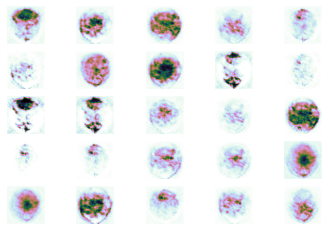

1401 [D loss: 0.691632, acc.: 66.02%] [G loss: 4.181440]
1402 [D loss: 0.615795, acc.: 76.17%] [G loss: 3.133008]
1403 [D loss: 1.089409, acc.: 31.25%] [G loss: 4.336150]
1404 [D loss: 0.900065, acc.: 66.80%] [G loss: 2.906657]
1405 [D loss: 1.023172, acc.: 35.55%] [G loss: 4.655087]
1406 [D loss: 0.711258, acc.: 72.66%] [G loss: 3.132349]
1407 [D loss: 1.037481, acc.: 36.72%] [G loss: 4.396939]
1408 [D loss: 0.746188, acc.: 71.48%] [G loss: 3.226677]
1409 [D loss: 0.873576, acc.: 48.83%] [G loss: 4.011901]
1410 [D loss: 0.853933, acc.: 66.02%] [G loss: 3.413880]
1411 [D loss: 0.821432, acc.: 62.50%] [G loss: 3.831771]
1412 [D loss: 0.581741, acc.: 78.52%] [G loss: 3.077368]
1413 [D loss: 0.878392, acc.: 51.56%] [G loss: 3.829696]
1414 [D loss: 0.723833, acc.: 74.22%] [G loss: 3.180800]
1415 [D loss: 1.016686, acc.: 40.23%] [G loss: 3.967730]
1416 [D loss: 0.768042, acc.: 69.14%] [G loss: 2.989589]
1417 [D loss: 1.165769, acc.: 31.25%] [G loss: 4.231723]
1418 [D loss: 0.897132, acc.: 6

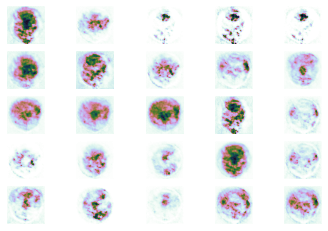

1601 [D loss: 0.623248, acc.: 78.52%] [G loss: 2.804842]
1602 [D loss: 0.799784, acc.: 56.64%] [G loss: 4.034935]
1603 [D loss: 0.811612, acc.: 71.88%] [G loss: 2.787471]
1604 [D loss: 0.591188, acc.: 68.75%] [G loss: 3.847504]
1605 [D loss: 0.704897, acc.: 75.00%] [G loss: 2.762203]
1606 [D loss: 0.904910, acc.: 38.28%] [G loss: 4.072383]
1607 [D loss: 0.750675, acc.: 73.05%] [G loss: 2.813477]
1608 [D loss: 0.823387, acc.: 39.84%] [G loss: 3.986691]
1609 [D loss: 0.597078, acc.: 78.12%] [G loss: 2.925370]
1610 [D loss: 0.794843, acc.: 47.27%] [G loss: 3.878184]
1611 [D loss: 0.594138, acc.: 77.73%] [G loss: 2.947077]
1612 [D loss: 0.868522, acc.: 41.41%] [G loss: 3.935602]
1613 [D loss: 0.735240, acc.: 74.22%] [G loss: 2.781440]
1614 [D loss: 0.917902, acc.: 51.95%] [G loss: 4.111436]
1615 [D loss: 0.837175, acc.: 71.88%] [G loss: 2.748378]
1616 [D loss: 0.826802, acc.: 50.00%] [G loss: 3.822015]
1617 [D loss: 0.761838, acc.: 75.00%] [G loss: 2.803761]
1618 [D loss: 0.829984, acc.: 5

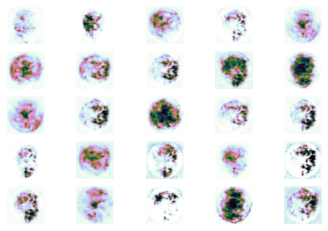

1801 [D loss: 0.721651, acc.: 72.27%] [G loss: 2.948026]
1802 [D loss: 0.992025, acc.: 46.88%] [G loss: 3.846708]
1803 [D loss: 0.630540, acc.: 74.61%] [G loss: 2.985759]
1804 [D loss: 1.039429, acc.: 48.83%] [G loss: 3.558151]
1805 [D loss: 0.795118, acc.: 68.75%] [G loss: 2.841561]
1806 [D loss: 0.792286, acc.: 50.78%] [G loss: 3.903702]
1807 [D loss: 0.950831, acc.: 62.89%] [G loss: 2.992000]
1808 [D loss: 0.825575, acc.: 56.25%] [G loss: 3.431666]
1809 [D loss: 0.947849, acc.: 63.28%] [G loss: 2.975587]
1810 [D loss: 0.863977, acc.: 62.89%] [G loss: 3.214111]
1811 [D loss: 0.802414, acc.: 67.19%] [G loss: 3.245247]
1812 [D loss: 0.767962, acc.: 65.23%] [G loss: 3.218595]
1813 [D loss: 1.035203, acc.: 41.02%] [G loss: 3.212200]
1814 [D loss: 0.680079, acc.: 71.48%] [G loss: 3.115346]
1815 [D loss: 0.672870, acc.: 66.80%] [G loss: 3.192131]
1816 [D loss: 0.769179, acc.: 62.89%] [G loss: 3.131052]
1817 [D loss: 0.670393, acc.: 71.48%] [G loss: 3.159690]
1818 [D loss: 0.844856, acc.: 5

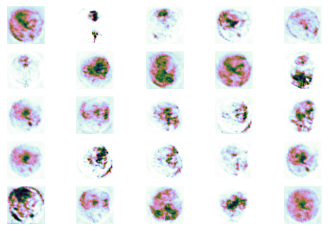

2001 [D loss: 0.677758, acc.: 70.70%] [G loss: 3.026667]
2002 [D loss: 0.848968, acc.: 50.00%] [G loss: 3.609584]
2003 [D loss: 0.580195, acc.: 75.39%] [G loss: 3.161880]
2004 [D loss: 1.017311, acc.: 40.23%] [G loss: 3.664198]
2005 [D loss: 0.623745, acc.: 76.56%] [G loss: 3.337049]
2006 [D loss: 0.619895, acc.: 71.88%] [G loss: 3.189265]
2007 [D loss: 0.650127, acc.: 69.53%] [G loss: 3.147854]
2008 [D loss: 0.656912, acc.: 74.22%] [G loss: 3.141606]
2009 [D loss: 0.621064, acc.: 74.22%] [G loss: 3.519337]
2010 [D loss: 0.716138, acc.: 73.44%] [G loss: 2.921516]
2011 [D loss: 0.531607, acc.: 75.78%] [G loss: 3.418133]
2012 [D loss: 0.611202, acc.: 76.56%] [G loss: 2.981025]
2013 [D loss: 0.566459, acc.: 75.78%] [G loss: 3.189821]
2014 [D loss: 0.823636, acc.: 60.16%] [G loss: 3.799031]
2015 [D loss: 0.592250, acc.: 75.39%] [G loss: 2.840508]
2016 [D loss: 0.714020, acc.: 57.03%] [G loss: 3.571133]
2017 [D loss: 0.575384, acc.: 76.95%] [G loss: 3.264236]
2018 [D loss: 0.628513, acc.: 6

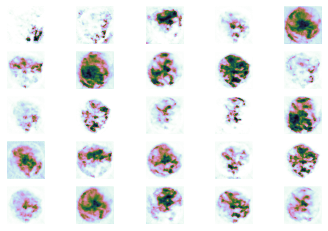

2201 [D loss: 0.647873, acc.: 61.72%] [G loss: 3.467294]
2202 [D loss: 0.747255, acc.: 64.84%] [G loss: 3.192448]
2203 [D loss: 0.726024, acc.: 64.06%] [G loss: 3.111947]
2204 [D loss: 0.602118, acc.: 73.05%] [G loss: 3.322020]
2205 [D loss: 0.786992, acc.: 59.38%] [G loss: 3.247048]
2206 [D loss: 0.630723, acc.: 70.31%] [G loss: 3.169755]
2207 [D loss: 0.782380, acc.: 62.11%] [G loss: 3.595363]
2208 [D loss: 0.721503, acc.: 68.75%] [G loss: 3.066532]
2209 [D loss: 0.604705, acc.: 74.61%] [G loss: 3.384864]
2210 [D loss: 0.699569, acc.: 63.67%] [G loss: 3.214105]
2211 [D loss: 0.639944, acc.: 69.53%] [G loss: 3.220909]
2212 [D loss: 0.561297, acc.: 74.22%] [G loss: 3.133158]
2213 [D loss: 0.780702, acc.: 55.47%] [G loss: 3.565040]
2214 [D loss: 0.571514, acc.: 73.05%] [G loss: 3.070813]
2215 [D loss: 0.686478, acc.: 62.50%] [G loss: 3.415738]
2216 [D loss: 0.651791, acc.: 69.14%] [G loss: 3.118063]
2217 [D loss: 0.604615, acc.: 71.09%] [G loss: 3.437924]
2218 [D loss: 0.591581, acc.: 7

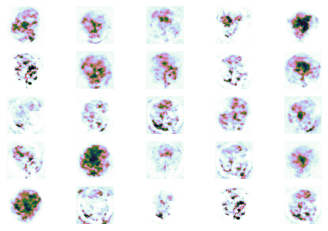

2401 [D loss: 0.386891, acc.: 85.16%] [G loss: 3.301543]
2402 [D loss: 0.545954, acc.: 75.00%] [G loss: 3.458258]
2403 [D loss: 0.410523, acc.: 87.11%] [G loss: 3.119452]
2404 [D loss: 0.431355, acc.: 80.86%] [G loss: 3.653768]
2405 [D loss: 0.526503, acc.: 78.12%] [G loss: 3.170669]
2406 [D loss: 0.576009, acc.: 75.39%] [G loss: 3.476810]
2407 [D loss: 0.434842, acc.: 81.64%] [G loss: 3.048984]
2408 [D loss: 0.525723, acc.: 75.78%] [G loss: 3.489556]
2409 [D loss: 0.462175, acc.: 82.42%] [G loss: 3.213099]
2410 [D loss: 0.539317, acc.: 76.17%] [G loss: 3.719058]
2411 [D loss: 0.479483, acc.: 80.08%] [G loss: 3.224605]
2412 [D loss: 0.592745, acc.: 71.09%] [G loss: 3.860160]
2413 [D loss: 0.717189, acc.: 64.84%] [G loss: 3.198998]
2414 [D loss: 0.659933, acc.: 66.41%] [G loss: 3.647419]
2415 [D loss: 0.385523, acc.: 87.11%] [G loss: 3.164052]
2416 [D loss: 0.599340, acc.: 69.53%] [G loss: 3.820467]
2417 [D loss: 0.760198, acc.: 68.36%] [G loss: 3.217677]
2418 [D loss: 0.723433, acc.: 5

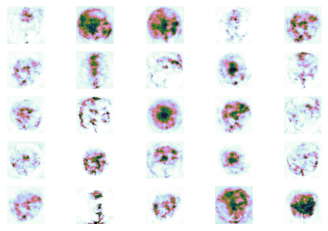

2601 [D loss: 0.490051, acc.: 79.30%] [G loss: 3.400039]
2602 [D loss: 0.524404, acc.: 75.78%] [G loss: 3.400805]
2603 [D loss: 0.467904, acc.: 82.42%] [G loss: 3.384814]
2604 [D loss: 0.396676, acc.: 84.77%] [G loss: 3.220155]
2605 [D loss: 0.612814, acc.: 71.88%] [G loss: 3.704493]
2606 [D loss: 0.357251, acc.: 87.50%] [G loss: 3.159694]
2607 [D loss: 0.552391, acc.: 70.31%] [G loss: 3.915798]
2608 [D loss: 0.432619, acc.: 82.03%] [G loss: 3.119766]
2609 [D loss: 0.544996, acc.: 73.83%] [G loss: 3.805237]
2610 [D loss: 0.448928, acc.: 79.69%] [G loss: 3.202116]
2611 [D loss: 0.491990, acc.: 76.56%] [G loss: 3.687395]
2612 [D loss: 0.484275, acc.: 78.12%] [G loss: 3.170519]
2613 [D loss: 0.425368, acc.: 83.59%] [G loss: 3.592586]
2614 [D loss: 0.501108, acc.: 78.91%] [G loss: 3.642827]
2615 [D loss: 0.429401, acc.: 82.42%] [G loss: 3.417324]
2616 [D loss: 0.450338, acc.: 83.20%] [G loss: 3.588784]
2617 [D loss: 0.343114, acc.: 88.28%] [G loss: 3.178271]
2618 [D loss: 0.585991, acc.: 6

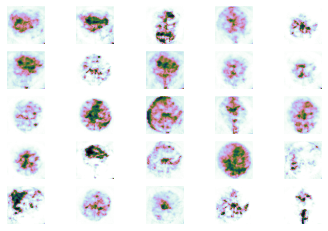

2801 [D loss: 0.350294, acc.: 83.98%] [G loss: 3.654696]
2802 [D loss: 0.283670, acc.: 91.41%] [G loss: 3.355721]
2803 [D loss: 0.365473, acc.: 89.06%] [G loss: 3.796239]
2804 [D loss: 0.342722, acc.: 88.28%] [G loss: 3.257803]
2805 [D loss: 0.441414, acc.: 82.42%] [G loss: 3.866826]
2806 [D loss: 0.423946, acc.: 84.77%] [G loss: 3.399522]
2807 [D loss: 0.417830, acc.: 84.38%] [G loss: 3.913659]
2808 [D loss: 0.416393, acc.: 84.77%] [G loss: 3.107806]
2809 [D loss: 0.391191, acc.: 83.98%] [G loss: 3.788353]
2810 [D loss: 0.346433, acc.: 88.67%] [G loss: 3.225884]
2811 [D loss: 0.432935, acc.: 83.59%] [G loss: 3.868797]
2812 [D loss: 0.491390, acc.: 80.86%] [G loss: 3.048174]
2813 [D loss: 0.392443, acc.: 85.55%] [G loss: 3.935997]
2814 [D loss: 0.355410, acc.: 87.11%] [G loss: 3.307144]
2815 [D loss: 0.514631, acc.: 75.78%] [G loss: 3.872051]
2816 [D loss: 0.547239, acc.: 80.86%] [G loss: 3.404200]
2817 [D loss: 0.382500, acc.: 87.50%] [G loss: 3.485806]
2818 [D loss: 0.349928, acc.: 8

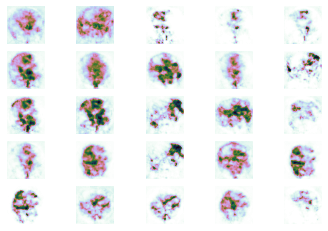

3001 [D loss: 0.325735, acc.: 87.50%] [G loss: 4.197683]
3002 [D loss: 0.329613, acc.: 89.84%] [G loss: 3.444064]
3003 [D loss: 0.307894, acc.: 90.23%] [G loss: 4.064475]
3004 [D loss: 0.300315, acc.: 89.45%] [G loss: 3.725046]
3005 [D loss: 0.419740, acc.: 83.98%] [G loss: 3.934536]
3006 [D loss: 0.370104, acc.: 85.55%] [G loss: 4.047656]
3007 [D loss: 0.396234, acc.: 86.72%] [G loss: 3.498322]
3008 [D loss: 0.267053, acc.: 92.19%] [G loss: 3.872708]
3009 [D loss: 0.200138, acc.: 94.53%] [G loss: 3.471977]
3010 [D loss: 0.401106, acc.: 86.72%] [G loss: 4.212123]
3011 [D loss: 0.396900, acc.: 87.50%] [G loss: 3.479668]
3012 [D loss: 0.345399, acc.: 89.06%] [G loss: 4.156549]
3013 [D loss: 0.311054, acc.: 88.28%] [G loss: 3.426127]
3014 [D loss: 0.327688, acc.: 87.11%] [G loss: 4.414110]
3015 [D loss: 0.272391, acc.: 89.45%] [G loss: 3.319900]
3016 [D loss: 0.237865, acc.: 94.92%] [G loss: 4.249909]
3017 [D loss: 0.213812, acc.: 92.97%] [G loss: 3.406111]
3018 [D loss: 0.425746, acc.: 8

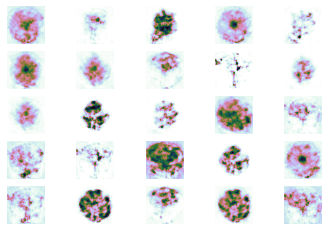

3201 [D loss: 0.365150, acc.: 83.20%] [G loss: 4.123655]
3202 [D loss: 0.255023, acc.: 91.80%] [G loss: 3.441619]
3203 [D loss: 0.326617, acc.: 89.06%] [G loss: 4.189023]
3204 [D loss: 0.329772, acc.: 87.11%] [G loss: 3.447776]
3205 [D loss: 0.235723, acc.: 94.92%] [G loss: 3.746377]
3206 [D loss: 0.377442, acc.: 84.77%] [G loss: 4.086724]
3207 [D loss: 0.281825, acc.: 89.06%] [G loss: 3.880047]
3208 [D loss: 0.272925, acc.: 91.41%] [G loss: 4.293814]
3209 [D loss: 0.401454, acc.: 85.55%] [G loss: 3.583970]
3210 [D loss: 0.215976, acc.: 94.14%] [G loss: 3.493755]
3211 [D loss: 0.283022, acc.: 92.19%] [G loss: 4.099213]
3212 [D loss: 0.326339, acc.: 89.84%] [G loss: 3.513466]
3213 [D loss: 0.276190, acc.: 91.02%] [G loss: 3.742307]
3214 [D loss: 0.416459, acc.: 85.55%] [G loss: 3.812113]
3215 [D loss: 0.231091, acc.: 92.19%] [G loss: 3.706919]
3216 [D loss: 0.265429, acc.: 92.19%] [G loss: 3.545207]
3217 [D loss: 0.148582, acc.: 96.48%] [G loss: 3.460969]
3218 [D loss: 0.405180, acc.: 8

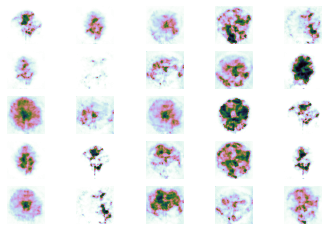

3401 [D loss: 0.241057, acc.: 92.19%] [G loss: 3.872286]
3402 [D loss: 0.290883, acc.: 91.80%] [G loss: 4.086159]
3403 [D loss: 0.220355, acc.: 93.75%] [G loss: 3.715276]
3404 [D loss: 0.240998, acc.: 95.31%] [G loss: 3.843574]
3405 [D loss: 0.262280, acc.: 91.80%] [G loss: 3.694753]
3406 [D loss: 0.308731, acc.: 90.62%] [G loss: 4.207819]
3407 [D loss: 0.450632, acc.: 79.69%] [G loss: 4.460855]
3408 [D loss: 0.146267, acc.: 94.53%] [G loss: 4.173985]
3409 [D loss: 0.214429, acc.: 95.70%] [G loss: 3.608886]
3410 [D loss: 0.335378, acc.: 87.89%] [G loss: 4.511432]
3411 [D loss: 0.253103, acc.: 90.62%] [G loss: 3.598907]
3412 [D loss: 0.272675, acc.: 92.97%] [G loss: 4.180248]
3413 [D loss: 0.177164, acc.: 94.53%] [G loss: 3.659878]
3414 [D loss: 0.324310, acc.: 90.62%] [G loss: 4.828809]
3415 [D loss: 0.278060, acc.: 89.45%] [G loss: 3.256813]
3416 [D loss: 0.254655, acc.: 93.36%] [G loss: 4.784219]
3417 [D loss: 0.215810, acc.: 92.97%] [G loss: 3.550058]
3418 [D loss: 0.286385, acc.: 9

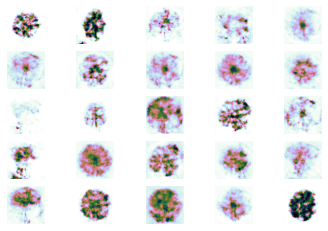

3601 [D loss: 0.213670, acc.: 95.31%] [G loss: 4.673675]
3602 [D loss: 0.245866, acc.: 91.80%] [G loss: 3.465986]
3603 [D loss: 0.214511, acc.: 95.70%] [G loss: 4.533722]
3604 [D loss: 0.203369, acc.: 93.36%] [G loss: 3.658094]
3605 [D loss: 0.160983, acc.: 96.88%] [G loss: 4.087136]
3606 [D loss: 0.207882, acc.: 94.14%] [G loss: 3.790622]
3607 [D loss: 0.140010, acc.: 96.48%] [G loss: 4.008089]
3608 [D loss: 0.262968, acc.: 91.41%] [G loss: 4.191055]
3609 [D loss: 0.179662, acc.: 94.92%] [G loss: 3.722620]
3610 [D loss: 0.189087, acc.: 96.09%] [G loss: 4.009743]
3611 [D loss: 0.225841, acc.: 91.41%] [G loss: 4.383467]
3612 [D loss: 0.183366, acc.: 93.36%] [G loss: 4.153024]
3613 [D loss: 0.137444, acc.: 95.70%] [G loss: 3.827442]
3614 [D loss: 0.161767, acc.: 96.48%] [G loss: 4.364046]
3615 [D loss: 0.298794, acc.: 92.19%] [G loss: 4.303201]
3616 [D loss: 0.182515, acc.: 95.31%] [G loss: 3.910348]
3617 [D loss: 0.152379, acc.: 97.27%] [G loss: 4.066287]
3618 [D loss: 0.199163, acc.: 9

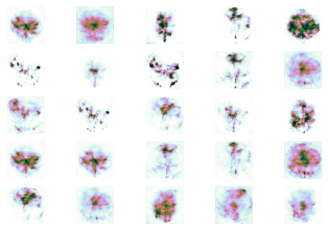

3801 [D loss: 0.654101, acc.: 74.61%] [G loss: 4.782236]
3802 [D loss: 0.212352, acc.: 92.19%] [G loss: 5.114899]
3803 [D loss: 0.137490, acc.: 96.09%] [G loss: 5.547277]
3804 [D loss: 0.314150, acc.: 88.67%] [G loss: 5.585292]
3805 [D loss: 0.306807, acc.: 90.62%] [G loss: 5.091244]
3806 [D loss: 0.122853, acc.: 97.27%] [G loss: 4.419721]
3807 [D loss: 0.310045, acc.: 89.45%] [G loss: 6.205386]
3808 [D loss: 0.282633, acc.: 89.84%] [G loss: 5.373776]
3809 [D loss: 0.405482, acc.: 83.59%] [G loss: 5.192074]
3810 [D loss: 0.199276, acc.: 92.97%] [G loss: 4.589080]
3811 [D loss: 0.220855, acc.: 92.97%] [G loss: 6.522300]
3812 [D loss: 0.280236, acc.: 90.23%] [G loss: 4.235377]
3813 [D loss: 0.172765, acc.: 94.14%] [G loss: 5.404250]
3814 [D loss: 0.150409, acc.: 93.75%] [G loss: 4.470292]
3815 [D loss: 0.255153, acc.: 91.41%] [G loss: 5.509529]
3816 [D loss: 0.177301, acc.: 92.97%] [G loss: 4.553171]
3817 [D loss: 0.148885, acc.: 96.09%] [G loss: 5.258919]
3818 [D loss: 0.446155, acc.: 8

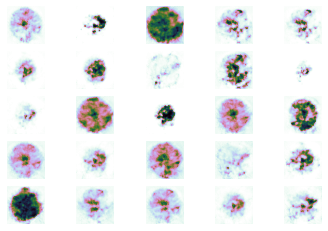

4001 [D loss: 0.105976, acc.: 97.27%] [G loss: 4.065660]
4002 [D loss: 0.112766, acc.: 97.27%] [G loss: 4.442933]
4003 [D loss: 0.159427, acc.: 94.92%] [G loss: 4.400420]
4004 [D loss: 0.154403, acc.: 96.88%] [G loss: 4.280687]
4005 [D loss: 0.150725, acc.: 95.70%] [G loss: 4.045554]
4006 [D loss: 0.070864, acc.: 98.83%] [G loss: 4.424364]
4007 [D loss: 0.245421, acc.: 93.36%] [G loss: 5.106657]
4008 [D loss: 0.122914, acc.: 95.70%] [G loss: 4.277597]
4009 [D loss: 0.105124, acc.: 98.05%] [G loss: 4.254792]
4010 [D loss: 0.151598, acc.: 96.48%] [G loss: 4.232133]
4011 [D loss: 0.077902, acc.: 98.05%] [G loss: 4.168903]
4012 [D loss: 0.170940, acc.: 96.09%] [G loss: 4.737501]
4013 [D loss: 0.151386, acc.: 94.92%] [G loss: 3.999599]
4014 [D loss: 0.117776, acc.: 97.66%] [G loss: 4.835453]
4015 [D loss: 0.138983, acc.: 95.31%] [G loss: 4.362473]
4016 [D loss: 0.249758, acc.: 91.80%] [G loss: 5.348731]
4017 [D loss: 0.109519, acc.: 96.09%] [G loss: 4.775964]
4018 [D loss: 0.162935, acc.: 9

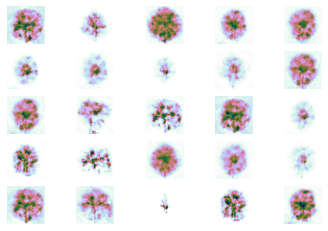

4201 [D loss: 0.099771, acc.: 98.44%] [G loss: 4.790568]
4202 [D loss: 0.084389, acc.: 98.05%] [G loss: 4.836505]
4203 [D loss: 0.124335, acc.: 96.48%] [G loss: 4.892581]
4204 [D loss: 0.124805, acc.: 96.88%] [G loss: 4.920940]
4205 [D loss: 0.226720, acc.: 93.75%] [G loss: 6.544785]
4206 [D loss: 0.166720, acc.: 93.36%] [G loss: 5.036081]
4207 [D loss: 0.128112, acc.: 98.05%] [G loss: 5.072195]
4208 [D loss: 0.096722, acc.: 97.27%] [G loss: 4.697293]
4209 [D loss: 0.238377, acc.: 91.80%] [G loss: 7.947292]
4210 [D loss: 0.236120, acc.: 91.02%] [G loss: 5.470915]
4211 [D loss: 0.075478, acc.: 99.22%] [G loss: 5.729135]
4212 [D loss: 0.075433, acc.: 98.05%] [G loss: 4.974343]
4213 [D loss: 0.183242, acc.: 95.31%] [G loss: 5.074835]
4214 [D loss: 0.241336, acc.: 91.80%] [G loss: 4.617492]
4215 [D loss: 0.094911, acc.: 96.09%] [G loss: 4.532759]
4216 [D loss: 0.163923, acc.: 95.31%] [G loss: 5.110729]
4217 [D loss: 0.071047, acc.: 97.27%] [G loss: 4.946909]
4218 [D loss: 0.073993, acc.: 9

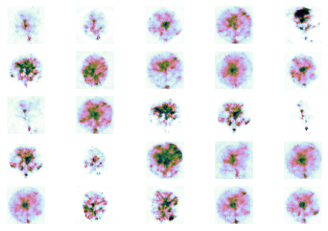

4401 [D loss: 0.077322, acc.: 96.48%] [G loss: 4.900794]
4402 [D loss: 0.201532, acc.: 94.53%] [G loss: 6.685247]
4403 [D loss: 0.138817, acc.: 94.92%] [G loss: 4.535547]
4404 [D loss: 0.126973, acc.: 98.05%] [G loss: 5.686986]
4405 [D loss: 0.107752, acc.: 95.31%] [G loss: 4.440682]
4406 [D loss: 0.076311, acc.: 98.05%] [G loss: 4.700958]
4407 [D loss: 0.210449, acc.: 92.58%] [G loss: 7.584049]
4408 [D loss: 0.605391, acc.: 75.39%] [G loss: 8.277456]
4409 [D loss: 0.240679, acc.: 89.84%] [G loss: 6.955626]
4410 [D loss: 0.218966, acc.: 93.36%] [G loss: 4.402757]
4411 [D loss: 0.128538, acc.: 97.66%] [G loss: 5.439920]
4412 [D loss: 0.108034, acc.: 95.31%] [G loss: 4.834375]
4413 [D loss: 0.182690, acc.: 95.31%] [G loss: 5.188931]
4414 [D loss: 0.151971, acc.: 96.09%] [G loss: 4.239515]
4415 [D loss: 0.139023, acc.: 96.48%] [G loss: 5.698932]
4416 [D loss: 0.116842, acc.: 96.48%] [G loss: 4.591855]
4417 [D loss: 0.163217, acc.: 95.70%] [G loss: 5.357794]
4418 [D loss: 0.066644, acc.: 9

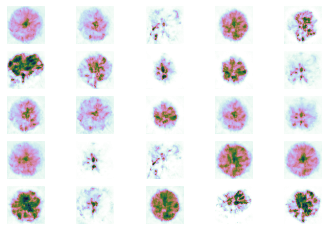

4601 [D loss: 0.046565, acc.: 98.44%] [G loss: 5.637557]
4602 [D loss: 0.112244, acc.: 97.27%] [G loss: 4.402885]
4603 [D loss: 0.055847, acc.: 98.44%] [G loss: 4.713456]
4604 [D loss: 0.086148, acc.: 97.27%] [G loss: 4.999508]
4605 [D loss: 0.161022, acc.: 96.48%] [G loss: 5.037977]
4606 [D loss: 0.125772, acc.: 96.88%] [G loss: 4.510412]
4607 [D loss: 0.062001, acc.: 98.44%] [G loss: 4.810190]
4608 [D loss: 0.132996, acc.: 95.31%] [G loss: 5.388468]
4609 [D loss: 0.119784, acc.: 97.66%] [G loss: 4.828237]
4610 [D loss: 0.103874, acc.: 96.09%] [G loss: 4.694664]
4611 [D loss: 0.062019, acc.: 98.83%] [G loss: 4.947942]
4612 [D loss: 0.104817, acc.: 97.27%] [G loss: 5.243815]
4613 [D loss: 0.086916, acc.: 98.05%] [G loss: 4.707871]
4614 [D loss: 0.095977, acc.: 97.27%] [G loss: 4.837400]
4615 [D loss: 0.098212, acc.: 97.66%] [G loss: 4.866859]
4616 [D loss: 0.055407, acc.: 98.44%] [G loss: 4.539670]
4617 [D loss: 0.205693, acc.: 93.36%] [G loss: 7.392387]
4618 [D loss: 0.245010, acc.: 9

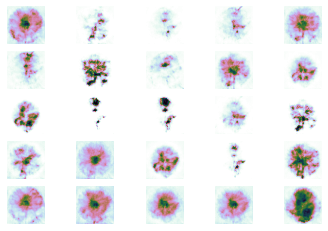

4801 [D loss: 0.155572, acc.: 94.14%] [G loss: 5.056346]
4802 [D loss: 0.042656, acc.: 99.22%] [G loss: 5.222334]
4803 [D loss: 0.201976, acc.: 94.14%] [G loss: 6.274300]
4804 [D loss: 0.291116, acc.: 88.67%] [G loss: 4.492738]
4805 [D loss: 0.065180, acc.: 98.83%] [G loss: 4.908086]
4806 [D loss: 0.065586, acc.: 98.83%] [G loss: 4.969110]
4807 [D loss: 0.083376, acc.: 98.44%] [G loss: 4.755892]
4808 [D loss: 0.097809, acc.: 98.44%] [G loss: 4.810079]
4809 [D loss: 0.074991, acc.: 98.44%] [G loss: 5.146021]
4810 [D loss: 0.072355, acc.: 98.44%] [G loss: 4.771133]
4811 [D loss: 0.146777, acc.: 96.48%] [G loss: 6.814196]
4812 [D loss: 0.192588, acc.: 91.41%] [G loss: 5.832731]
4813 [D loss: 0.037537, acc.: 99.22%] [G loss: 5.359425]
4814 [D loss: 0.107483, acc.: 98.44%] [G loss: 5.691079]
4815 [D loss: 0.077763, acc.: 98.05%] [G loss: 4.760314]
4816 [D loss: 0.128364, acc.: 97.66%] [G loss: 5.639149]
4817 [D loss: 0.069772, acc.: 97.27%] [G loss: 5.727697]
4818 [D loss: 0.217747, acc.: 9

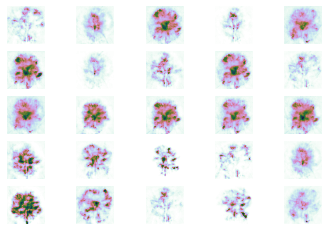

5001 [D loss: 0.093041, acc.: 98.44%] [G loss: 8.133890]
5002 [D loss: 0.070894, acc.: 97.27%] [G loss: 6.262339]
5003 [D loss: 0.202171, acc.: 92.97%] [G loss: 9.328951]
5004 [D loss: 0.194953, acc.: 92.19%] [G loss: 5.443155]
5005 [D loss: 0.162187, acc.: 90.62%] [G loss: 9.517900]
5006 [D loss: 0.148682, acc.: 94.14%] [G loss: 6.819224]
5007 [D loss: 0.184044, acc.: 92.19%] [G loss: 7.030377]
5008 [D loss: 0.087641, acc.: 97.27%] [G loss: 5.688691]
5009 [D loss: 0.155870, acc.: 94.92%] [G loss: 7.991291]
5010 [D loss: 0.133864, acc.: 94.92%] [G loss: 5.114193]
5011 [D loss: 0.123009, acc.: 96.09%] [G loss: 7.404622]
5012 [D loss: 0.054136, acc.: 97.66%] [G loss: 6.700248]
5013 [D loss: 0.185562, acc.: 91.80%] [G loss: 7.378226]
5014 [D loss: 0.107493, acc.: 96.88%] [G loss: 5.455500]
5015 [D loss: 0.115934, acc.: 97.27%] [G loss: 7.802490]
5016 [D loss: 0.119313, acc.: 96.88%] [G loss: 5.800267]
5017 [D loss: 0.174950, acc.: 94.53%] [G loss: 9.259569]
5018 [D loss: 0.125894, acc.: 9

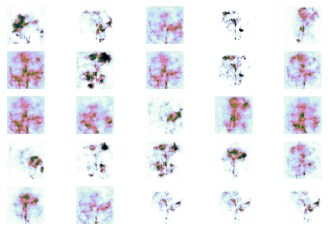

5201 [D loss: 0.106770, acc.: 96.88%] [G loss: 5.853613]
5202 [D loss: 0.104559, acc.: 96.88%] [G loss: 4.873265]
5203 [D loss: 0.059743, acc.: 99.61%] [G loss: 5.120191]
5204 [D loss: 0.051272, acc.: 98.83%] [G loss: 4.891212]
5205 [D loss: 0.073115, acc.: 99.22%] [G loss: 5.214736]
5206 [D loss: 0.057316, acc.: 99.22%] [G loss: 4.940331]
5207 [D loss: 0.072124, acc.: 99.22%] [G loss: 5.983769]
5208 [D loss: 0.072427, acc.: 98.44%] [G loss: 5.541944]
5209 [D loss: 0.054199, acc.: 99.61%] [G loss: 4.974767]
5210 [D loss: 0.089979, acc.: 98.05%] [G loss: 5.213612]
5211 [D loss: 0.087802, acc.: 97.27%] [G loss: 6.806461]
5212 [D loss: 0.102866, acc.: 96.88%] [G loss: 5.446582]
5213 [D loss: 0.086454, acc.: 98.44%] [G loss: 5.247595]
5214 [D loss: 0.067623, acc.: 99.22%] [G loss: 4.918887]
5215 [D loss: 0.042695, acc.: 100.00%] [G loss: 5.012323]
5216 [D loss: 0.035269, acc.: 100.00%] [G loss: 4.896185]
5217 [D loss: 0.121586, acc.: 97.27%] [G loss: 6.735518]
5218 [D loss: 0.090950, acc.:

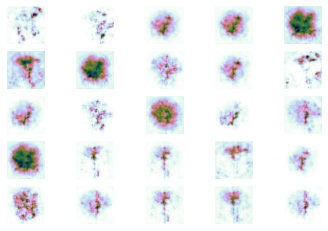

5401 [D loss: 0.057870, acc.: 99.22%] [G loss: 5.012854]
5402 [D loss: 0.105127, acc.: 98.44%] [G loss: 5.809391]
5403 [D loss: 0.076059, acc.: 98.05%] [G loss: 4.894967]
5404 [D loss: 0.064395, acc.: 99.22%] [G loss: 5.492207]
5405 [D loss: 0.055076, acc.: 98.05%] [G loss: 4.963984]
5406 [D loss: 0.063868, acc.: 99.22%] [G loss: 5.053823]
5407 [D loss: 0.070432, acc.: 99.22%] [G loss: 5.136250]
5408 [D loss: 0.077100, acc.: 98.05%] [G loss: 4.931924]
5409 [D loss: 0.048320, acc.: 98.83%] [G loss: 5.227401]
5410 [D loss: 0.047635, acc.: 99.61%] [G loss: 5.226882]
5411 [D loss: 0.084952, acc.: 98.44%] [G loss: 5.148850]
5412 [D loss: 0.084392, acc.: 98.05%] [G loss: 5.430073]
5413 [D loss: 0.057671, acc.: 99.22%] [G loss: 5.018657]
5414 [D loss: 0.065842, acc.: 98.05%] [G loss: 6.647323]
5415 [D loss: 0.221916, acc.: 91.41%] [G loss: 8.386133]
5416 [D loss: 0.106007, acc.: 96.09%] [G loss: 5.733072]
5417 [D loss: 0.192881, acc.: 94.92%] [G loss: 7.405923]
5418 [D loss: 0.054465, acc.: 9

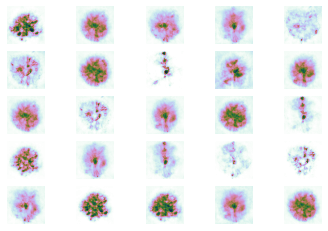

5601 [D loss: 0.088377, acc.: 97.66%] [G loss: 5.032629]
5602 [D loss: 0.043250, acc.: 99.22%] [G loss: 5.367404]
5603 [D loss: 0.050874, acc.: 98.44%] [G loss: 4.925876]
5604 [D loss: 0.062485, acc.: 99.22%] [G loss: 6.254982]
5605 [D loss: 0.072984, acc.: 98.05%] [G loss: 5.141354]
5606 [D loss: 0.065858, acc.: 98.44%] [G loss: 5.933133]
5607 [D loss: 0.083435, acc.: 98.05%] [G loss: 4.951699]
5608 [D loss: 0.075999, acc.: 98.83%] [G loss: 5.814959]
5609 [D loss: 0.051196, acc.: 98.83%] [G loss: 5.932590]
5610 [D loss: 0.127097, acc.: 97.27%] [G loss: 6.659803]
5611 [D loss: 0.059555, acc.: 98.05%] [G loss: 5.390726]
5612 [D loss: 0.052018, acc.: 99.61%] [G loss: 6.092309]
5613 [D loss: 0.088717, acc.: 97.66%] [G loss: 5.093028]
5614 [D loss: 0.094044, acc.: 97.66%] [G loss: 8.856891]
5615 [D loss: 0.188094, acc.: 93.36%] [G loss: 5.095272]
5616 [D loss: 0.053955, acc.: 98.44%] [G loss: 6.148564]
5617 [D loss: 0.023143, acc.: 99.22%] [G loss: 6.056439]
5618 [D loss: 0.038818, acc.: 9

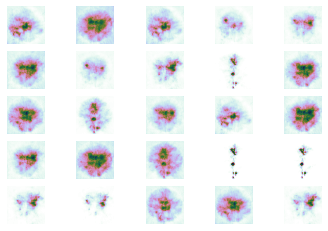

5801 [D loss: 0.190390, acc.: 91.41%] [G loss: 8.813207]
5802 [D loss: 0.195933, acc.: 90.62%] [G loss: 6.243467]
5803 [D loss: 0.125186, acc.: 93.36%] [G loss: 7.330228]
5804 [D loss: 0.062861, acc.: 97.66%] [G loss: 6.802490]
5805 [D loss: 0.303689, acc.: 85.16%] [G loss: 11.776495]
5806 [D loss: 0.275259, acc.: 88.28%] [G loss: 8.301423]
5807 [D loss: 0.209071, acc.: 93.36%] [G loss: 7.143482]
5808 [D loss: 0.039788, acc.: 99.22%] [G loss: 6.200076]
5809 [D loss: 0.160496, acc.: 94.92%] [G loss: 7.341903]
5810 [D loss: 0.071871, acc.: 97.66%] [G loss: 6.236672]
5811 [D loss: 0.081810, acc.: 98.83%] [G loss: 6.531190]
5812 [D loss: 0.164772, acc.: 94.53%] [G loss: 6.002572]
5813 [D loss: 0.074665, acc.: 97.27%] [G loss: 6.134923]
5814 [D loss: 0.232703, acc.: 93.36%] [G loss: 10.954186]
5815 [D loss: 0.720397, acc.: 70.31%] [G loss: 16.449268]
5816 [D loss: 0.277991, acc.: 87.50%] [G loss: 11.070740]
5817 [D loss: 0.154347, acc.: 95.70%] [G loss: 8.234419]
5818 [D loss: 0.082846, acc

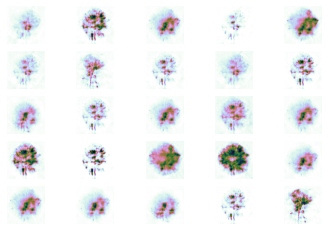

6001 [D loss: 0.111978, acc.: 94.92%] [G loss: 7.337106]
6002 [D loss: 0.084078, acc.: 96.88%] [G loss: 5.234663]
6003 [D loss: 0.131486, acc.: 97.27%] [G loss: 8.033052]
6004 [D loss: 0.144639, acc.: 92.97%] [G loss: 4.665658]
6005 [D loss: 0.141172, acc.: 96.09%] [G loss: 8.486929]
6006 [D loss: 0.076445, acc.: 96.48%] [G loss: 8.390516]
6007 [D loss: 0.140663, acc.: 96.09%] [G loss: 4.687188]
6008 [D loss: 0.162572, acc.: 94.14%] [G loss: 9.528549]
6009 [D loss: 0.274127, acc.: 90.62%] [G loss: 4.191787]
6010 [D loss: 0.367355, acc.: 86.72%] [G loss: 12.510151]
6011 [D loss: 0.388331, acc.: 87.11%] [G loss: 7.616612]
6012 [D loss: 0.202871, acc.: 94.53%] [G loss: 7.640876]
6013 [D loss: 0.076457, acc.: 96.88%] [G loss: 6.024201]
6014 [D loss: 0.162777, acc.: 94.92%] [G loss: 7.229258]
6015 [D loss: 0.238493, acc.: 92.97%] [G loss: 6.991845]
6016 [D loss: 0.226211, acc.: 91.80%] [G loss: 6.678404]
6017 [D loss: 0.077772, acc.: 98.44%] [G loss: 5.822947]
6018 [D loss: 0.142426, acc.: 

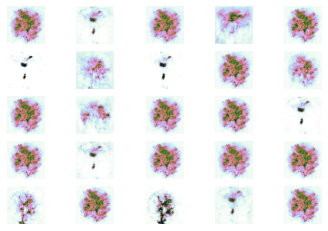

6201 [D loss: 0.025952, acc.: 99.61%] [G loss: 6.029053]
6202 [D loss: 0.039881, acc.: 99.61%] [G loss: 6.418444]
6203 [D loss: 0.050730, acc.: 98.83%] [G loss: 6.515052]
6204 [D loss: 0.089181, acc.: 98.05%] [G loss: 6.461840]
6205 [D loss: 0.063219, acc.: 99.22%] [G loss: 8.310862]
6206 [D loss: 0.077478, acc.: 97.66%] [G loss: 6.969966]
6207 [D loss: 0.016911, acc.: 100.00%] [G loss: 6.674574]
6208 [D loss: 0.017504, acc.: 100.00%] [G loss: 6.465628]
6209 [D loss: 0.083968, acc.: 96.88%] [G loss: 9.526738]
6210 [D loss: 0.128509, acc.: 95.70%] [G loss: 7.264910]
6211 [D loss: 0.073441, acc.: 99.22%] [G loss: 11.134800]
6212 [D loss: 0.075132, acc.: 98.05%] [G loss: 9.082869]
6213 [D loss: 0.072725, acc.: 98.83%] [G loss: 6.855622]
6214 [D loss: 0.053303, acc.: 99.22%] [G loss: 7.632900]
6215 [D loss: 0.037760, acc.: 99.61%] [G loss: 6.240911]
6216 [D loss: 0.076462, acc.: 100.00%] [G loss: 10.396653]
6217 [D loss: 0.162069, acc.: 92.58%] [G loss: 7.153746]
6218 [D loss: 0.018745, ac

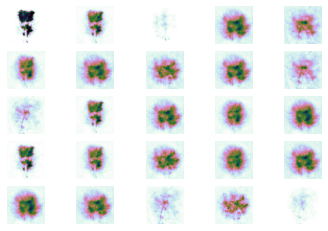

6401 [D loss: 0.077911, acc.: 98.05%] [G loss: 7.898665]
6402 [D loss: 0.315140, acc.: 83.20%] [G loss: 14.469415]
6403 [D loss: 0.207441, acc.: 94.53%] [G loss: 14.103275]
6404 [D loss: 0.277350, acc.: 92.97%] [G loss: 5.511135]
6405 [D loss: 1.074963, acc.: 60.94%] [G loss: 21.405918]
6406 [D loss: 1.131620, acc.: 79.69%] [G loss: 18.805864]
6407 [D loss: 0.228353, acc.: 92.97%] [G loss: 7.640843]
6408 [D loss: 1.219656, acc.: 76.56%] [G loss: 13.821857]
6409 [D loss: 0.111942, acc.: 96.09%] [G loss: 14.543759]
6410 [D loss: 0.483338, acc.: 84.77%] [G loss: 7.605709]
6411 [D loss: 0.244502, acc.: 94.14%] [G loss: 9.927347]
6412 [D loss: 0.128318, acc.: 96.48%] [G loss: 8.577723]
6413 [D loss: 1.001594, acc.: 66.80%] [G loss: 24.301609]
6414 [D loss: 1.879195, acc.: 73.05%] [G loss: 12.336756]
6415 [D loss: 0.240243, acc.: 95.70%] [G loss: 7.678438]
6416 [D loss: 0.186955, acc.: 89.06%] [G loss: 11.383482]
6417 [D loss: 0.127427, acc.: 96.48%] [G loss: 10.257532]
6418 [D loss: 0.98295

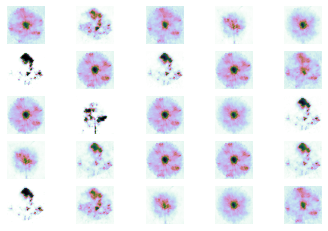

6601 [D loss: 0.100167, acc.: 96.88%] [G loss: 7.153348]
6602 [D loss: 0.077193, acc.: 99.61%] [G loss: 8.562246]
6603 [D loss: 0.042298, acc.: 99.61%] [G loss: 7.795392]
6604 [D loss: 0.036680, acc.: 99.61%] [G loss: 6.295231]
6605 [D loss: 0.069286, acc.: 98.05%] [G loss: 4.692109]
6606 [D loss: 0.042791, acc.: 100.00%] [G loss: 5.879760]
6607 [D loss: 0.041138, acc.: 99.22%] [G loss: 5.677890]
6608 [D loss: 0.062335, acc.: 98.05%] [G loss: 5.369259]
6609 [D loss: 0.028386, acc.: 99.61%] [G loss: 5.538696]
6610 [D loss: 0.125757, acc.: 97.66%] [G loss: 6.585347]
6611 [D loss: 0.048429, acc.: 99.22%] [G loss: 6.374509]
6612 [D loss: 0.102068, acc.: 99.22%] [G loss: 5.388043]
6613 [D loss: 0.087063, acc.: 98.44%] [G loss: 5.210341]
6614 [D loss: 0.026404, acc.: 100.00%] [G loss: 5.140791]
6615 [D loss: 0.107008, acc.: 98.44%] [G loss: 6.145050]
6616 [D loss: 0.049500, acc.: 98.05%] [G loss: 5.460082]
6617 [D loss: 0.047296, acc.: 99.61%] [G loss: 5.238897]
6618 [D loss: 0.065803, acc.:

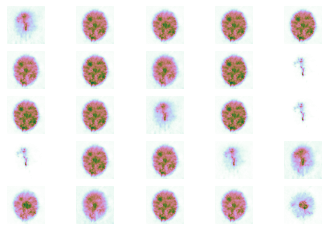

6801 [D loss: 0.101673, acc.: 97.66%] [G loss: 4.761414]
6802 [D loss: 0.035128, acc.: 99.22%] [G loss: 5.194218]
6803 [D loss: 0.060911, acc.: 99.22%] [G loss: 5.242324]
6804 [D loss: 0.060272, acc.: 98.83%] [G loss: 4.770312]
6805 [D loss: 0.035821, acc.: 99.22%] [G loss: 5.043299]
6806 [D loss: 0.023294, acc.: 99.22%] [G loss: 5.154522]
6807 [D loss: 0.036871, acc.: 99.22%] [G loss: 5.001570]
6808 [D loss: 0.097526, acc.: 98.44%] [G loss: 5.363143]
6809 [D loss: 0.059467, acc.: 98.83%] [G loss: 5.297382]
6810 [D loss: 0.050896, acc.: 99.22%] [G loss: 5.258701]
6811 [D loss: 0.031985, acc.: 99.22%] [G loss: 5.026335]
6812 [D loss: 0.071845, acc.: 98.05%] [G loss: 4.990906]
6813 [D loss: 0.166912, acc.: 97.66%] [G loss: 7.663525]
6814 [D loss: 0.035236, acc.: 99.22%] [G loss: 8.932501]
6815 [D loss: 0.100440, acc.: 96.48%] [G loss: 5.462811]
6816 [D loss: 0.057494, acc.: 99.61%] [G loss: 6.357444]
6817 [D loss: 0.085843, acc.: 97.66%] [G loss: 5.355569]
6818 [D loss: 0.062155, acc.: 9

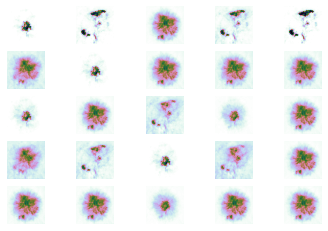

7001 [D loss: 0.038285, acc.: 99.22%] [G loss: 6.547140]
7002 [D loss: 0.037634, acc.: 99.61%] [G loss: 5.375942]
7003 [D loss: 0.040030, acc.: 100.00%] [G loss: 7.817260]
7004 [D loss: 0.057023, acc.: 99.22%] [G loss: 7.214619]
7005 [D loss: 0.029041, acc.: 100.00%] [G loss: 6.579510]
7006 [D loss: 0.017416, acc.: 100.00%] [G loss: 5.705581]
7007 [D loss: 0.098613, acc.: 96.48%] [G loss: 8.048984]
7008 [D loss: 0.087183, acc.: 97.66%] [G loss: 6.971565]
7009 [D loss: 0.030168, acc.: 99.22%] [G loss: 6.716718]
7010 [D loss: 0.013588, acc.: 100.00%] [G loss: 6.213865]
7011 [D loss: 0.018324, acc.: 100.00%] [G loss: 5.467920]
7012 [D loss: 0.018598, acc.: 100.00%] [G loss: 5.901044]
7013 [D loss: 0.018287, acc.: 100.00%] [G loss: 5.428119]
7014 [D loss: 0.025050, acc.: 100.00%] [G loss: 5.512905]
7015 [D loss: 0.052398, acc.: 99.22%] [G loss: 5.911753]
7016 [D loss: 0.038268, acc.: 99.61%] [G loss: 5.627952]
7017 [D loss: 0.059096, acc.: 99.61%] [G loss: 8.152048]
7018 [D loss: 0.059944,

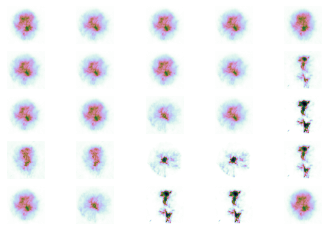

7201 [D loss: 0.082396, acc.: 98.44%] [G loss: 6.155455]
7202 [D loss: 0.076635, acc.: 98.05%] [G loss: 5.317285]
7203 [D loss: 0.081024, acc.: 97.27%] [G loss: 6.549815]
7204 [D loss: 0.109161, acc.: 97.27%] [G loss: 4.946170]
7205 [D loss: 0.344541, acc.: 94.14%] [G loss: 11.246743]
7206 [D loss: 0.216331, acc.: 92.97%] [G loss: 10.130806]
7207 [D loss: 0.406558, acc.: 83.98%] [G loss: 8.663846]
7208 [D loss: 0.058090, acc.: 97.27%] [G loss: 7.176907]
7209 [D loss: 0.423827, acc.: 94.53%] [G loss: 9.360395]
7210 [D loss: 0.142728, acc.: 95.70%] [G loss: 5.819183]
7211 [D loss: 0.232651, acc.: 91.41%] [G loss: 10.967966]
7212 [D loss: 0.328930, acc.: 88.28%] [G loss: 9.785376]
7213 [D loss: 0.189362, acc.: 94.92%] [G loss: 7.435080]
7214 [D loss: 0.046068, acc.: 98.05%] [G loss: 8.213259]
7215 [D loss: 0.025877, acc.: 99.22%] [G loss: 6.433449]
7216 [D loss: 0.383229, acc.: 90.23%] [G loss: 14.420574]
7217 [D loss: 0.320568, acc.: 89.06%] [G loss: 8.404561]
7218 [D loss: 0.305426, acc

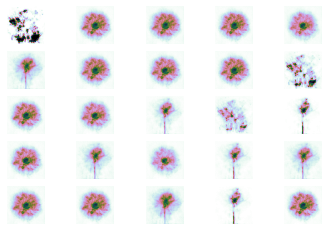

7401 [D loss: 0.047509, acc.: 97.66%] [G loss: 5.939791]
7402 [D loss: 0.093199, acc.: 98.44%] [G loss: 6.789263]
7403 [D loss: 0.071329, acc.: 97.66%] [G loss: 5.871168]
7404 [D loss: 0.029831, acc.: 100.00%] [G loss: 5.668723]
7405 [D loss: 0.159213, acc.: 96.88%] [G loss: 6.858570]
7406 [D loss: 0.109189, acc.: 96.09%] [G loss: 6.522555]
7407 [D loss: 0.086776, acc.: 97.27%] [G loss: 6.433872]
7408 [D loss: 0.036633, acc.: 99.61%] [G loss: 5.521842]
7409 [D loss: 0.129292, acc.: 96.09%] [G loss: 8.084650]
7410 [D loss: 0.167242, acc.: 93.36%] [G loss: 5.770482]
7411 [D loss: 0.111496, acc.: 98.83%] [G loss: 10.535830]
7412 [D loss: 0.101968, acc.: 95.70%] [G loss: 9.120240]
7413 [D loss: 0.035894, acc.: 99.22%] [G loss: 6.305242]
7414 [D loss: 0.037196, acc.: 100.00%] [G loss: 5.858518]
7415 [D loss: 0.026957, acc.: 99.22%] [G loss: 5.158890]
7416 [D loss: 0.045613, acc.: 99.22%] [G loss: 5.848345]
7417 [D loss: 0.076799, acc.: 98.05%] [G loss: 4.945048]
7418 [D loss: 0.069437, acc.

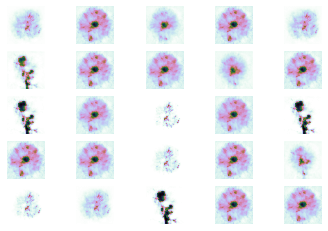

7601 [D loss: 0.088764, acc.: 98.83%] [G loss: 7.347386]
7602 [D loss: 0.064193, acc.: 98.44%] [G loss: 7.634497]
7603 [D loss: 0.050069, acc.: 98.83%] [G loss: 5.979947]
7604 [D loss: 0.050245, acc.: 99.61%] [G loss: 6.497844]
7605 [D loss: 0.073304, acc.: 97.27%] [G loss: 5.696848]
7606 [D loss: 0.102368, acc.: 99.22%] [G loss: 8.807379]
7607 [D loss: 0.078961, acc.: 96.09%] [G loss: 6.975377]
7608 [D loss: 0.034262, acc.: 99.22%] [G loss: 5.649224]
7609 [D loss: 0.107052, acc.: 99.22%] [G loss: 9.617957]
7610 [D loss: 0.047051, acc.: 98.05%] [G loss: 9.347311]
7611 [D loss: 0.106938, acc.: 98.05%] [G loss: 5.561330]
7612 [D loss: 0.041744, acc.: 99.61%] [G loss: 5.863001]
7613 [D loss: 0.037948, acc.: 98.44%] [G loss: 5.764774]
7614 [D loss: 0.138231, acc.: 98.05%] [G loss: 8.400133]
7615 [D loss: 0.117656, acc.: 98.05%] [G loss: 8.060762]
7616 [D loss: 0.152731, acc.: 96.88%] [G loss: 6.638344]
7617 [D loss: 0.113760, acc.: 97.27%] [G loss: 5.518504]
7618 [D loss: 0.141178, acc.: 9

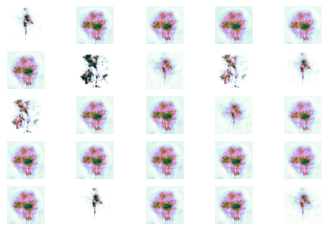

7801 [D loss: 0.128074, acc.: 99.22%] [G loss: 7.713994]
7802 [D loss: 0.069839, acc.: 98.44%] [G loss: 9.720591]
7803 [D loss: 0.169540, acc.: 94.14%] [G loss: 5.790653]
7804 [D loss: 0.102241, acc.: 96.88%] [G loss: 6.704906]
7805 [D loss: 0.053725, acc.: 98.44%] [G loss: 7.035716]
7806 [D loss: 0.063111, acc.: 98.83%] [G loss: 5.800147]
7807 [D loss: 0.080631, acc.: 98.44%] [G loss: 5.390077]
7808 [D loss: 0.056927, acc.: 100.00%] [G loss: 6.138679]
7809 [D loss: 0.088135, acc.: 98.44%] [G loss: 5.553583]
7810 [D loss: 0.078948, acc.: 98.83%] [G loss: 5.568758]
7811 [D loss: 0.104323, acc.: 98.44%] [G loss: 7.254773]
7812 [D loss: 0.038427, acc.: 98.83%] [G loss: 6.844732]
7813 [D loss: 0.111022, acc.: 98.44%] [G loss: 5.110444]
7814 [D loss: 0.071383, acc.: 100.00%] [G loss: 7.837357]
7815 [D loss: 0.059254, acc.: 98.05%] [G loss: 7.745145]
7816 [D loss: 0.090697, acc.: 97.27%] [G loss: 5.854553]
7817 [D loss: 0.032742, acc.: 100.00%] [G loss: 6.296603]
7818 [D loss: 0.046692, acc.

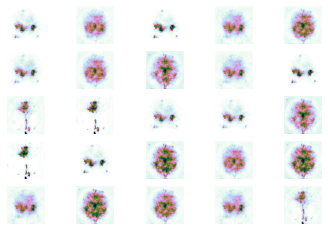

8001 [D loss: 0.031674, acc.: 99.22%] [G loss: 8.531096]
8002 [D loss: 0.113082, acc.: 97.66%] [G loss: 6.859220]
8003 [D loss: 0.018679, acc.: 100.00%] [G loss: 6.911600]
8004 [D loss: 0.042427, acc.: 99.22%] [G loss: 7.721536]
8005 [D loss: 0.047473, acc.: 97.66%] [G loss: 6.589586]
8006 [D loss: 0.017225, acc.: 100.00%] [G loss: 5.912588]
8007 [D loss: 0.088729, acc.: 99.61%] [G loss: 12.573769]
8008 [D loss: 0.118851, acc.: 95.70%] [G loss: 12.388590]
8009 [D loss: 0.061987, acc.: 99.22%] [G loss: 10.381659]
8010 [D loss: 0.039102, acc.: 98.44%] [G loss: 8.517741]
8011 [D loss: 0.035184, acc.: 99.61%] [G loss: 6.168528]
8012 [D loss: 0.029407, acc.: 99.61%] [G loss: 5.684475]
8013 [D loss: 0.039251, acc.: 99.22%] [G loss: 6.351373]
8014 [D loss: 0.045179, acc.: 98.83%] [G loss: 6.903751]
8015 [D loss: 0.033937, acc.: 99.22%] [G loss: 5.714234]
8016 [D loss: 0.042882, acc.: 100.00%] [G loss: 8.853205]
8017 [D loss: 0.031876, acc.: 99.22%] [G loss: 9.454078]
8018 [D loss: 0.065400, a

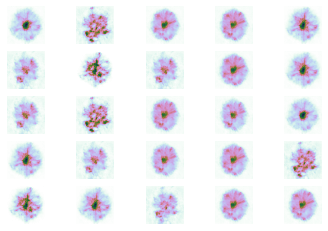

8201 [D loss: 0.113799, acc.: 94.92%] [G loss: 9.908207]
8202 [D loss: 0.119207, acc.: 95.70%] [G loss: 7.842252]
8203 [D loss: 0.049392, acc.: 98.44%] [G loss: 5.797322]
8204 [D loss: 0.082299, acc.: 96.09%] [G loss: 7.115706]
8205 [D loss: 0.073052, acc.: 97.27%] [G loss: 6.011825]
8206 [D loss: 0.057532, acc.: 99.22%] [G loss: 5.635507]
8207 [D loss: 0.045556, acc.: 98.83%] [G loss: 5.346162]
8208 [D loss: 0.039480, acc.: 98.83%] [G loss: 5.568291]
8209 [D loss: 0.091356, acc.: 96.88%] [G loss: 4.484840]
8210 [D loss: 0.072285, acc.: 97.66%] [G loss: 5.766415]
8211 [D loss: 0.092367, acc.: 98.44%] [G loss: 5.648199]
8212 [D loss: 0.042904, acc.: 98.44%] [G loss: 5.224584]
8213 [D loss: 0.067343, acc.: 97.66%] [G loss: 5.701838]
8214 [D loss: 0.061269, acc.: 98.83%] [G loss: 5.759489]
8215 [D loss: 0.072703, acc.: 98.44%] [G loss: 5.216463]
8216 [D loss: 0.111574, acc.: 95.31%] [G loss: 6.396690]
8217 [D loss: 0.081554, acc.: 97.27%] [G loss: 5.694084]
8218 [D loss: 0.072631, acc.: 9

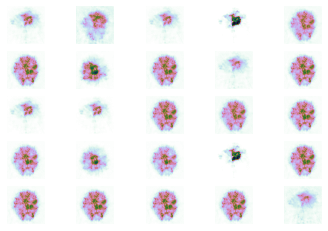

8401 [D loss: 0.076545, acc.: 97.66%] [G loss: 4.803182]
8402 [D loss: 0.043915, acc.: 99.61%] [G loss: 5.943872]
8403 [D loss: 0.022250, acc.: 100.00%] [G loss: 5.872253]
8404 [D loss: 0.039052, acc.: 99.61%] [G loss: 5.246027]
8405 [D loss: 0.062251, acc.: 99.61%] [G loss: 6.368531]
8406 [D loss: 0.068544, acc.: 98.44%] [G loss: 6.132016]
8407 [D loss: 0.031195, acc.: 99.61%] [G loss: 5.957850]
8408 [D loss: 0.034037, acc.: 99.61%] [G loss: 5.605678]
8409 [D loss: 0.050444, acc.: 98.83%] [G loss: 5.776179]
8410 [D loss: 0.045888, acc.: 98.44%] [G loss: 5.553559]
8411 [D loss: 0.028774, acc.: 100.00%] [G loss: 6.377204]
8412 [D loss: 0.074887, acc.: 98.05%] [G loss: 5.634881]
8413 [D loss: 0.030562, acc.: 100.00%] [G loss: 5.599975]
8414 [D loss: 0.074088, acc.: 98.83%] [G loss: 6.363534]
8415 [D loss: 0.062166, acc.: 98.44%] [G loss: 5.523362]
8416 [D loss: 0.045217, acc.: 98.44%] [G loss: 5.878989]
8417 [D loss: 0.018558, acc.: 100.00%] [G loss: 6.406703]
8418 [D loss: 0.023265, acc

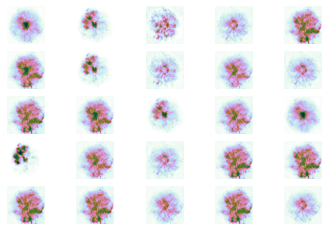

8601 [D loss: 0.015837, acc.: 100.00%] [G loss: 6.088373]
8602 [D loss: 0.047983, acc.: 98.83%] [G loss: 6.737543]
8603 [D loss: 0.058871, acc.: 98.83%] [G loss: 5.723639]
8604 [D loss: 0.020929, acc.: 100.00%] [G loss: 5.733463]
8605 [D loss: 0.011953, acc.: 99.61%] [G loss: 6.885354]
8606 [D loss: 0.012154, acc.: 100.00%] [G loss: 6.434400]
8607 [D loss: 0.015678, acc.: 100.00%] [G loss: 5.821791]
8608 [D loss: 0.021412, acc.: 100.00%] [G loss: 6.403736]
8609 [D loss: 0.028842, acc.: 99.61%] [G loss: 5.762868]
8610 [D loss: 0.028091, acc.: 99.61%] [G loss: 6.357947]
8611 [D loss: 0.065798, acc.: 96.88%] [G loss: 8.186374]
8612 [D loss: 0.018238, acc.: 99.61%] [G loss: 8.474412]
8613 [D loss: 0.101958, acc.: 98.44%] [G loss: 10.910649]
8614 [D loss: 0.026754, acc.: 99.22%] [G loss: 11.315217]
8615 [D loss: 0.066991, acc.: 98.05%] [G loss: 8.822261]
8616 [D loss: 0.004081, acc.: 100.00%] [G loss: 7.920773]
8617 [D loss: 0.016719, acc.: 99.61%] [G loss: 5.670482]
8618 [D loss: 0.057383,

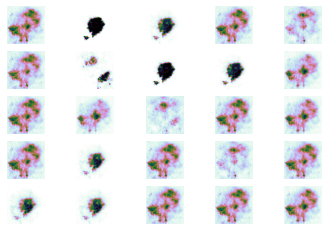

8801 [D loss: 0.123947, acc.: 94.14%] [G loss: 9.924932]
8802 [D loss: 0.115879, acc.: 93.75%] [G loss: 9.420701]
8803 [D loss: 0.080017, acc.: 98.05%] [G loss: 7.144805]
8804 [D loss: 0.372171, acc.: 92.19%] [G loss: 8.201690]
8805 [D loss: 0.305988, acc.: 82.03%] [G loss: 15.663797]
8806 [D loss: 0.754971, acc.: 72.27%] [G loss: 10.182279]
8807 [D loss: 0.242140, acc.: 93.75%] [G loss: 10.247663]
8808 [D loss: 0.016723, acc.: 99.61%] [G loss: 10.187734]
8809 [D loss: 0.116468, acc.: 96.48%] [G loss: 5.360909]
8810 [D loss: 0.288389, acc.: 80.86%] [G loss: 10.304607]
8811 [D loss: 0.459701, acc.: 89.84%] [G loss: 16.531200]
8812 [D loss: 0.477156, acc.: 82.42%] [G loss: 6.078421]
8813 [D loss: 0.166037, acc.: 92.97%] [G loss: 7.448752]
8814 [D loss: 0.113624, acc.: 96.88%] [G loss: 7.155320]
8815 [D loss: 0.234708, acc.: 92.97%] [G loss: 8.173399]
8816 [D loss: 0.227413, acc.: 94.14%] [G loss: 6.218790]
8817 [D loss: 0.227412, acc.: 95.31%] [G loss: 7.730173]
8818 [D loss: 0.097115, a

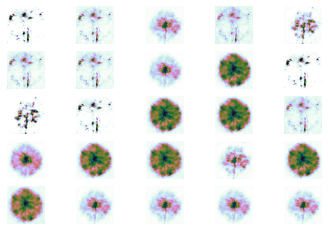

9001 [D loss: 0.118770, acc.: 99.61%] [G loss: 9.391003]
9002 [D loss: 0.111527, acc.: 96.48%] [G loss: 7.702494]
9003 [D loss: 0.118817, acc.: 93.36%] [G loss: 11.945621]
9004 [D loss: 0.317001, acc.: 87.89%] [G loss: 4.340947]
9005 [D loss: 0.363409, acc.: 84.38%] [G loss: 16.720316]
9006 [D loss: 0.401109, acc.: 89.84%] [G loss: 14.983016]
9007 [D loss: 0.121657, acc.: 96.09%] [G loss: 9.110025]
9008 [D loss: 0.031156, acc.: 98.83%] [G loss: 6.627315]
9009 [D loss: 0.066379, acc.: 99.22%] [G loss: 5.864630]
9010 [D loss: 0.068455, acc.: 99.61%] [G loss: 8.024105]
9011 [D loss: 0.185276, acc.: 94.53%] [G loss: 8.015187]
9012 [D loss: 0.197360, acc.: 89.45%] [G loss: 11.615982]
9013 [D loss: 0.246341, acc.: 91.80%] [G loss: 8.748444]
9014 [D loss: 0.137742, acc.: 98.44%] [G loss: 8.632123]
9015 [D loss: 0.174600, acc.: 95.31%] [G loss: 10.728568]
9016 [D loss: 0.266701, acc.: 92.19%] [G loss: 7.381893]
9017 [D loss: 0.264529, acc.: 89.84%] [G loss: 14.516298]
9018 [D loss: 0.443913, a

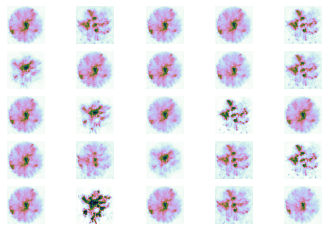

9201 [D loss: 0.078586, acc.: 97.66%] [G loss: 6.209653]
9202 [D loss: 0.066275, acc.: 99.22%] [G loss: 7.597707]
9203 [D loss: 0.079024, acc.: 98.44%] [G loss: 5.778792]
9204 [D loss: 0.056794, acc.: 98.83%] [G loss: 5.574307]
9205 [D loss: 0.047793, acc.: 99.22%] [G loss: 6.258261]
9206 [D loss: 0.021787, acc.: 100.00%] [G loss: 7.072794]
9207 [D loss: 0.058781, acc.: 97.66%] [G loss: 4.817602]
9208 [D loss: 0.065835, acc.: 99.61%] [G loss: 5.716365]
9209 [D loss: 0.038316, acc.: 99.22%] [G loss: 5.679606]
9210 [D loss: 0.062419, acc.: 98.83%] [G loss: 5.468987]
9211 [D loss: 0.087517, acc.: 95.31%] [G loss: 9.114828]
9212 [D loss: 0.144316, acc.: 93.75%] [G loss: 6.091471]
9213 [D loss: 0.082668, acc.: 99.22%] [G loss: 8.822378]
9214 [D loss: 0.053606, acc.: 97.66%] [G loss: 7.832920]
9215 [D loss: 0.075542, acc.: 98.44%] [G loss: 6.005017]
9216 [D loss: 0.026009, acc.: 99.61%] [G loss: 5.081733]
9217 [D loss: 0.049041, acc.: 99.22%] [G loss: 5.216971]
9218 [D loss: 0.032061, acc.: 

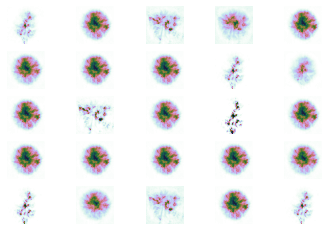

9401 [D loss: 0.050766, acc.: 99.22%] [G loss: 6.655083]
9402 [D loss: 0.060986, acc.: 97.66%] [G loss: 5.465267]
9403 [D loss: 0.161924, acc.: 97.27%] [G loss: 9.871818]
9404 [D loss: 0.062037, acc.: 97.66%] [G loss: 10.142446]
9405 [D loss: 0.088072, acc.: 95.31%] [G loss: 7.239907]
9406 [D loss: 0.017579, acc.: 99.61%] [G loss: 5.631503]
9407 [D loss: 0.149120, acc.: 95.31%] [G loss: 9.558195]
9408 [D loss: 0.073251, acc.: 96.88%] [G loss: 8.343502]
9409 [D loss: 0.041983, acc.: 100.00%] [G loss: 7.067055]
9410 [D loss: 0.041145, acc.: 98.44%] [G loss: 6.438769]
9411 [D loss: 0.015698, acc.: 100.00%] [G loss: 5.706170]
9412 [D loss: 0.064806, acc.: 97.66%] [G loss: 7.450463]
9413 [D loss: 0.050586, acc.: 99.22%] [G loss: 6.751743]
9414 [D loss: 0.049591, acc.: 98.83%] [G loss: 6.389514]
9415 [D loss: 0.028255, acc.: 100.00%] [G loss: 6.339585]
9416 [D loss: 0.086323, acc.: 96.88%] [G loss: 7.521296]
9417 [D loss: 0.057805, acc.: 98.44%] [G loss: 7.264233]
9418 [D loss: 0.063378, acc

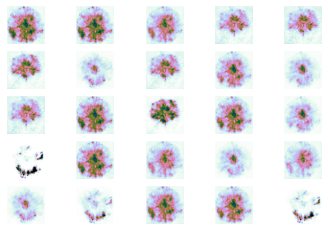

9601 [D loss: 0.101700, acc.: 97.27%] [G loss: 6.187833]
9602 [D loss: 0.076948, acc.: 98.44%] [G loss: 5.143996]
9603 [D loss: 0.052662, acc.: 99.61%] [G loss: 5.980407]
9604 [D loss: 0.052166, acc.: 98.83%] [G loss: 5.815678]
9605 [D loss: 0.063007, acc.: 98.44%] [G loss: 5.434621]
9606 [D loss: 0.057964, acc.: 98.83%] [G loss: 6.319467]
9607 [D loss: 0.058125, acc.: 99.61%] [G loss: 6.725355]
9608 [D loss: 0.062852, acc.: 97.27%] [G loss: 5.923810]
9609 [D loss: 0.064397, acc.: 98.05%] [G loss: 6.103397]
9610 [D loss: 0.059878, acc.: 98.44%] [G loss: 5.680383]
9611 [D loss: 0.074967, acc.: 98.83%] [G loss: 6.015717]
9612 [D loss: 0.212507, acc.: 94.53%] [G loss: 8.681513]
9613 [D loss: 0.148293, acc.: 96.48%] [G loss: 8.965560]
9614 [D loss: 0.175584, acc.: 96.48%] [G loss: 7.751430]
9615 [D loss: 0.019490, acc.: 99.22%] [G loss: 7.394972]
9616 [D loss: 0.024889, acc.: 100.00%] [G loss: 6.272595]
9617 [D loss: 0.028731, acc.: 99.22%] [G loss: 5.475041]
9618 [D loss: 0.069618, acc.: 

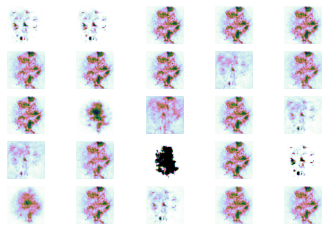

9801 [D loss: 0.040584, acc.: 99.61%] [G loss: 6.493222]
9802 [D loss: 0.033758, acc.: 100.00%] [G loss: 7.394378]
9803 [D loss: 0.034948, acc.: 99.22%] [G loss: 6.511620]
9804 [D loss: 0.048542, acc.: 99.61%] [G loss: 8.365469]
9805 [D loss: 0.099217, acc.: 93.75%] [G loss: 11.145144]
9806 [D loss: 0.249466, acc.: 87.89%] [G loss: 12.432530]
9807 [D loss: 0.075813, acc.: 99.22%] [G loss: 18.267595]
9808 [D loss: 0.296527, acc.: 90.62%] [G loss: 9.412382]
9809 [D loss: 0.086282, acc.: 93.75%] [G loss: 8.409554]
9810 [D loss: 0.031626, acc.: 99.61%] [G loss: 8.796674]
9811 [D loss: 0.025027, acc.: 99.61%] [G loss: 8.525059]
9812 [D loss: 0.031797, acc.: 99.61%] [G loss: 7.681482]
9813 [D loss: 0.038337, acc.: 99.22%] [G loss: 7.841060]
9814 [D loss: 0.069990, acc.: 99.22%] [G loss: 6.326413]
9815 [D loss: 0.034862, acc.: 99.61%] [G loss: 7.483080]
9816 [D loss: 0.075975, acc.: 98.44%] [G loss: 6.009019]
9817 [D loss: 0.060771, acc.: 99.61%] [G loss: 8.368793]
9818 [D loss: 0.063117, acc

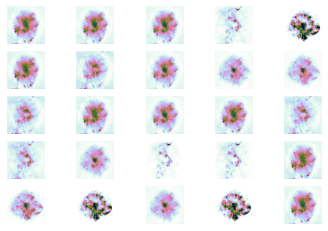

10001 [D loss: 0.039525, acc.: 99.22%] [G loss: 5.002568]
10002 [D loss: 0.025845, acc.: 100.00%] [G loss: 5.516969]
10003 [D loss: 0.016815, acc.: 100.00%] [G loss: 5.459523]
10004 [D loss: 0.041456, acc.: 99.22%] [G loss: 4.807008]
10005 [D loss: 0.028387, acc.: 100.00%] [G loss: 5.578606]
10006 [D loss: 0.008196, acc.: 99.61%] [G loss: 6.309721]
10007 [D loss: 0.058191, acc.: 98.05%] [G loss: 4.593145]
10008 [D loss: 0.023138, acc.: 100.00%] [G loss: 5.363047]
10009 [D loss: 0.010652, acc.: 100.00%] [G loss: 5.690122]
10010 [D loss: 0.026864, acc.: 98.83%] [G loss: 5.020474]
10011 [D loss: 0.028204, acc.: 100.00%] [G loss: 5.199251]
10012 [D loss: 0.016031, acc.: 100.00%] [G loss: 5.532725]
10013 [D loss: 0.025494, acc.: 100.00%] [G loss: 6.214953]
10014 [D loss: 0.018773, acc.: 99.61%] [G loss: 6.134367]
10015 [D loss: 0.024984, acc.: 99.61%] [G loss: 5.428556]
10016 [D loss: 0.031639, acc.: 99.22%] [G loss: 5.457619]
10017 [D loss: 0.039483, acc.: 98.44%] [G loss: 5.524212]
10018 

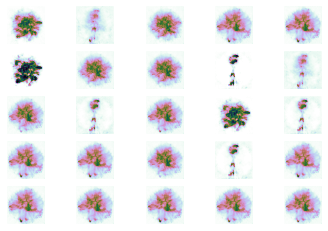

10201 [D loss: 0.013430, acc.: 100.00%] [G loss: 5.908393]
10202 [D loss: 0.034423, acc.: 99.22%] [G loss: 5.745042]
10203 [D loss: 0.023378, acc.: 100.00%] [G loss: 6.555360]
10204 [D loss: 0.019157, acc.: 99.22%] [G loss: 6.264315]
10205 [D loss: 0.035333, acc.: 99.61%] [G loss: 7.613835]
10206 [D loss: 0.031656, acc.: 99.61%] [G loss: 6.577581]
10207 [D loss: 0.043955, acc.: 98.44%] [G loss: 5.717755]
10208 [D loss: 0.017652, acc.: 99.61%] [G loss: 6.467693]
10209 [D loss: 0.023571, acc.: 99.61%] [G loss: 6.067904]
10210 [D loss: 0.024151, acc.: 99.61%] [G loss: 6.462448]
10211 [D loss: 0.022710, acc.: 99.22%] [G loss: 6.334743]
10212 [D loss: 0.048205, acc.: 98.44%] [G loss: 5.503268]
10213 [D loss: 0.051647, acc.: 99.61%] [G loss: 8.239429]
10214 [D loss: 0.025862, acc.: 99.22%] [G loss: 7.936806]
10215 [D loss: 0.028563, acc.: 100.00%] [G loss: 8.314130]
10216 [D loss: 0.010771, acc.: 100.00%] [G loss: 7.785718]
10217 [D loss: 0.023896, acc.: 99.61%] [G loss: 6.590858]
10218 [D l

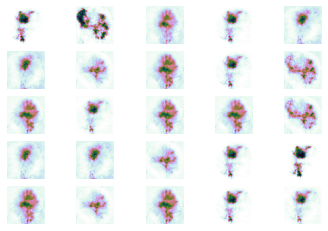

10401 [D loss: 0.342037, acc.: 93.36%] [G loss: 15.031597]
10402 [D loss: 0.275176, acc.: 91.02%] [G loss: 10.151859]
10403 [D loss: 0.086468, acc.: 98.44%] [G loss: 7.417730]
10404 [D loss: 0.031753, acc.: 98.83%] [G loss: 5.990896]
10405 [D loss: 0.039269, acc.: 99.22%] [G loss: 5.645576]
10406 [D loss: 0.041312, acc.: 99.22%] [G loss: 5.439878]
10407 [D loss: 0.026389, acc.: 100.00%] [G loss: 5.639100]
10408 [D loss: 0.098456, acc.: 98.05%] [G loss: 6.128030]
10409 [D loss: 0.060138, acc.: 98.44%] [G loss: 5.622464]
10410 [D loss: 0.040336, acc.: 98.83%] [G loss: 5.422840]
10411 [D loss: 0.063186, acc.: 98.83%] [G loss: 6.165704]
10412 [D loss: 0.052176, acc.: 98.05%] [G loss: 5.555575]
10413 [D loss: 0.129302, acc.: 98.44%] [G loss: 8.062498]
10414 [D loss: 0.065771, acc.: 98.44%] [G loss: 8.221235]
10415 [D loss: 0.040376, acc.: 98.05%] [G loss: 5.678402]
10416 [D loss: 0.026939, acc.: 100.00%] [G loss: 5.463905]
10417 [D loss: 0.021552, acc.: 100.00%] [G loss: 6.062220]
10418 [D 

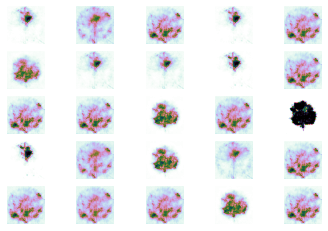

10601 [D loss: 0.063004, acc.: 99.22%] [G loss: 6.424480]
10602 [D loss: 0.047537, acc.: 99.61%] [G loss: 8.178229]
10603 [D loss: 0.045419, acc.: 98.83%] [G loss: 6.806216]
10604 [D loss: 0.102965, acc.: 99.22%] [G loss: 11.788441]
10605 [D loss: 0.067187, acc.: 98.05%] [G loss: 10.972431]
10606 [D loss: 0.076995, acc.: 95.70%] [G loss: 10.237379]
10607 [D loss: 0.075753, acc.: 98.05%] [G loss: 8.328414]
10608 [D loss: 0.275453, acc.: 82.42%] [G loss: 22.849789]
10609 [D loss: 0.425971, acc.: 79.69%] [G loss: 12.009249]
10610 [D loss: 0.954937, acc.: 80.86%] [G loss: 20.425419]
10611 [D loss: 0.111227, acc.: 94.53%] [G loss: 20.807861]
10612 [D loss: 0.413138, acc.: 85.55%] [G loss: 7.162956]
10613 [D loss: 0.816615, acc.: 70.70%] [G loss: 14.148760]
10614 [D loss: 0.112007, acc.: 97.27%] [G loss: 17.950981]
10615 [D loss: 0.578315, acc.: 81.25%] [G loss: 7.244914]
10616 [D loss: 0.039546, acc.: 100.00%] [G loss: 5.548452]
10617 [D loss: 0.340900, acc.: 95.70%] [G loss: 10.856314]
106

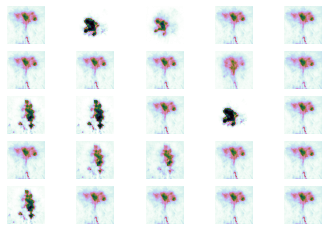

10801 [D loss: 0.048699, acc.: 98.05%] [G loss: 5.211529]
10802 [D loss: 0.038959, acc.: 100.00%] [G loss: 5.101366]
10803 [D loss: 0.037665, acc.: 99.61%] [G loss: 5.746464]
10804 [D loss: 0.057986, acc.: 98.83%] [G loss: 5.205940]
10805 [D loss: 0.048687, acc.: 99.22%] [G loss: 5.872981]
10806 [D loss: 0.082964, acc.: 97.66%] [G loss: 6.438253]
10807 [D loss: 0.029246, acc.: 99.61%] [G loss: 6.542450]
10808 [D loss: 0.072643, acc.: 98.83%] [G loss: 6.897663]
10809 [D loss: 0.025657, acc.: 100.00%] [G loss: 6.458070]
10810 [D loss: 0.042153, acc.: 99.22%] [G loss: 4.747327]
10811 [D loss: 0.090031, acc.: 98.44%] [G loss: 7.492507]
10812 [D loss: 0.042651, acc.: 98.83%] [G loss: 7.217875]
10813 [D loss: 0.030690, acc.: 99.61%] [G loss: 6.069531]
10814 [D loss: 0.026502, acc.: 99.61%] [G loss: 5.608304]
10815 [D loss: 0.015669, acc.: 100.00%] [G loss: 5.773389]
10816 [D loss: 0.034512, acc.: 98.83%] [G loss: 4.932921]
10817 [D loss: 0.027374, acc.: 99.61%] [G loss: 5.172859]
10818 [D lo

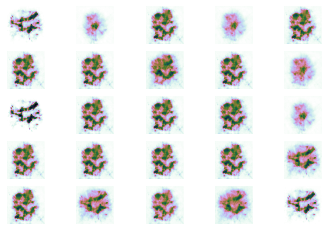

11001 [D loss: 0.029901, acc.: 99.61%] [G loss: 6.131793]
11002 [D loss: 0.020613, acc.: 100.00%] [G loss: 5.873299]
11003 [D loss: 0.039548, acc.: 100.00%] [G loss: 6.981664]
11004 [D loss: 0.038589, acc.: 99.22%] [G loss: 6.015407]
11005 [D loss: 0.016144, acc.: 100.00%] [G loss: 5.857350]
11006 [D loss: 0.025219, acc.: 100.00%] [G loss: 6.748972]
11007 [D loss: 0.033976, acc.: 99.61%] [G loss: 6.305994]
11008 [D loss: 0.030905, acc.: 99.61%] [G loss: 5.939322]
11009 [D loss: 0.023893, acc.: 99.61%] [G loss: 6.039415]
11010 [D loss: 0.033586, acc.: 100.00%] [G loss: 6.288599]
11011 [D loss: 0.012571, acc.: 100.00%] [G loss: 6.653058]
11012 [D loss: 0.030161, acc.: 100.00%] [G loss: 6.485807]
11013 [D loss: 0.029936, acc.: 100.00%] [G loss: 6.565465]
11014 [D loss: 0.038198, acc.: 99.22%] [G loss: 6.210492]
11015 [D loss: 0.024771, acc.: 100.00%] [G loss: 6.577121]
11016 [D loss: 0.040552, acc.: 98.83%] [G loss: 6.924469]
11017 [D loss: 0.019781, acc.: 100.00%] [G loss: 6.586052]
1101

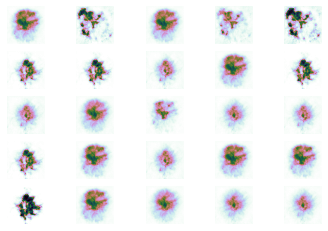

11201 [D loss: 0.201876, acc.: 96.48%] [G loss: 7.802383]
11202 [D loss: 0.161318, acc.: 94.92%] [G loss: 8.172952]
11203 [D loss: 0.073601, acc.: 97.66%] [G loss: 6.068668]
11204 [D loss: 0.163481, acc.: 92.97%] [G loss: 9.240116]
11205 [D loss: 0.076983, acc.: 97.66%] [G loss: 8.973110]
11206 [D loss: 0.060037, acc.: 99.22%] [G loss: 7.286596]
11207 [D loss: 0.049212, acc.: 98.44%] [G loss: 5.785412]
11208 [D loss: 0.034820, acc.: 99.61%] [G loss: 5.249481]
11209 [D loss: 0.058402, acc.: 98.83%] [G loss: 5.065685]
11210 [D loss: 0.021653, acc.: 100.00%] [G loss: 5.208263]
11211 [D loss: 0.024970, acc.: 100.00%] [G loss: 5.156486]
11212 [D loss: 0.029966, acc.: 100.00%] [G loss: 5.113979]
11213 [D loss: 0.030017, acc.: 99.61%] [G loss: 5.177894]
11214 [D loss: 0.041893, acc.: 99.22%] [G loss: 5.012727]
11215 [D loss: 0.065816, acc.: 98.44%] [G loss: 5.759751]
11216 [D loss: 0.020367, acc.: 100.00%] [G loss: 5.856205]
11217 [D loss: 0.034449, acc.: 99.61%] [G loss: 5.091893]
11218 [D l

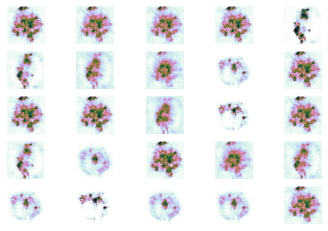

11401 [D loss: 0.070170, acc.: 98.83%] [G loss: 6.898063]
11402 [D loss: 0.016792, acc.: 99.61%] [G loss: 7.635352]
11403 [D loss: 0.011037, acc.: 100.00%] [G loss: 6.613074]
11404 [D loss: 0.013296, acc.: 99.61%] [G loss: 5.972896]
11405 [D loss: 0.015275, acc.: 100.00%] [G loss: 6.243720]
11406 [D loss: 0.017427, acc.: 99.61%] [G loss: 6.128319]
11407 [D loss: 0.016516, acc.: 100.00%] [G loss: 5.957621]
11408 [D loss: 0.016744, acc.: 100.00%] [G loss: 5.741092]
11409 [D loss: 0.012020, acc.: 100.00%] [G loss: 6.017727]
11410 [D loss: 0.010712, acc.: 100.00%] [G loss: 5.751336]
11411 [D loss: 0.022317, acc.: 100.00%] [G loss: 6.563291]
11412 [D loss: 0.013603, acc.: 100.00%] [G loss: 6.275294]
11413 [D loss: 0.024759, acc.: 99.22%] [G loss: 5.857866]
11414 [D loss: 0.021185, acc.: 100.00%] [G loss: 6.643996]
11415 [D loss: 0.015711, acc.: 100.00%] [G loss: 6.731380]
11416 [D loss: 0.011786, acc.: 100.00%] [G loss: 6.380279]
11417 [D loss: 0.018491, acc.: 99.61%] [G loss: 5.868740]
114

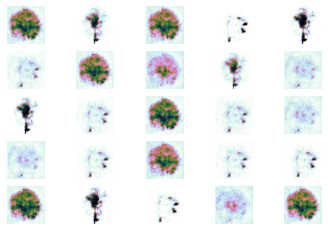

11601 [D loss: 0.071698, acc.: 98.83%] [G loss: 7.673558]
11602 [D loss: 0.032688, acc.: 99.22%] [G loss: 6.922027]
11603 [D loss: 0.140433, acc.: 96.09%] [G loss: 15.092048]
11604 [D loss: 0.205786, acc.: 94.92%] [G loss: 14.543186]
11605 [D loss: 0.202379, acc.: 94.14%] [G loss: 10.256865]
11606 [D loss: 0.034224, acc.: 98.83%] [G loss: 6.517038]
11607 [D loss: 0.252817, acc.: 87.11%] [G loss: 16.643204]
11608 [D loss: 0.460292, acc.: 86.33%] [G loss: 16.522560]
11609 [D loss: 0.263353, acc.: 91.41%] [G loss: 13.335924]
11610 [D loss: 0.018043, acc.: 99.22%] [G loss: 10.089071]
11611 [D loss: 0.038373, acc.: 99.22%] [G loss: 6.231873]
11612 [D loss: 0.389353, acc.: 82.42%] [G loss: 16.968611]
11613 [D loss: 0.658682, acc.: 76.95%] [G loss: 17.290821]
11614 [D loss: 0.342206, acc.: 92.58%] [G loss: 13.774986]
11615 [D loss: 0.073971, acc.: 96.48%] [G loss: 9.420542]
11616 [D loss: 0.022334, acc.: 99.61%] [G loss: 7.149437]
11617 [D loss: 0.024342, acc.: 100.00%] [G loss: 6.516150]
116

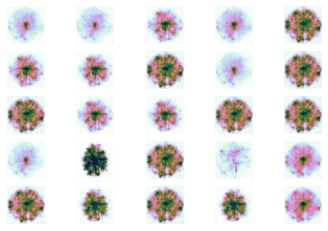

11801 [D loss: 0.100669, acc.: 97.66%] [G loss: 10.579346]
11802 [D loss: 0.084549, acc.: 96.88%] [G loss: 8.572744]
11803 [D loss: 0.076349, acc.: 98.05%] [G loss: 6.751124]
11804 [D loss: 0.036662, acc.: 98.44%] [G loss: 5.892978]
11805 [D loss: 0.032029, acc.: 99.61%] [G loss: 5.884158]
11806 [D loss: 0.058001, acc.: 99.22%] [G loss: 6.892810]
11807 [D loss: 0.171483, acc.: 95.70%] [G loss: 6.956103]
11808 [D loss: 0.108337, acc.: 98.44%] [G loss: 6.487326]
11809 [D loss: 0.234138, acc.: 87.50%] [G loss: 10.155373]
11810 [D loss: 0.101721, acc.: 95.70%] [G loss: 9.912515]
11811 [D loss: 0.025116, acc.: 99.61%] [G loss: 7.086151]
11812 [D loss: 0.056987, acc.: 98.83%] [G loss: 7.335579]
11813 [D loss: 0.037237, acc.: 98.44%] [G loss: 6.151974]
11814 [D loss: 0.072555, acc.: 100.00%] [G loss: 6.940232]
11815 [D loss: 0.110143, acc.: 96.48%] [G loss: 5.582155]
11816 [D loss: 0.070755, acc.: 100.00%] [G loss: 7.140567]
11817 [D loss: 0.208159, acc.: 94.92%] [G loss: 8.990051]
11818 [D l

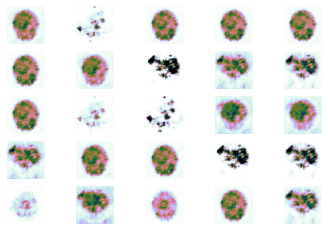

12001 [D loss: 0.057475, acc.: 99.61%] [G loss: 8.576373]
12002 [D loss: 0.043738, acc.: 99.22%] [G loss: 8.664546]
12003 [D loss: 0.086146, acc.: 99.22%] [G loss: 7.299916]
12004 [D loss: 0.013444, acc.: 99.61%] [G loss: 6.669228]
12005 [D loss: 0.015878, acc.: 100.00%] [G loss: 5.632416]
12006 [D loss: 0.047775, acc.: 97.66%] [G loss: 8.521200]
12007 [D loss: 0.027381, acc.: 99.61%] [G loss: 7.353396]
12008 [D loss: 0.027920, acc.: 100.00%] [G loss: 5.635344]
12009 [D loss: 0.106502, acc.: 98.44%] [G loss: 7.777169]
12010 [D loss: 0.075535, acc.: 98.44%] [G loss: 6.755445]
12011 [D loss: 0.016790, acc.: 100.00%] [G loss: 6.158250]
12012 [D loss: 0.022965, acc.: 100.00%] [G loss: 6.239158]
12013 [D loss: 0.022452, acc.: 99.22%] [G loss: 5.595398]
12014 [D loss: 0.048676, acc.: 99.61%] [G loss: 7.028235]
12015 [D loss: 0.019246, acc.: 99.22%] [G loss: 6.726171]
12016 [D loss: 0.082164, acc.: 99.22%] [G loss: 5.913331]
12017 [D loss: 0.017492, acc.: 100.00%] [G loss: 5.777637]
12018 [D 

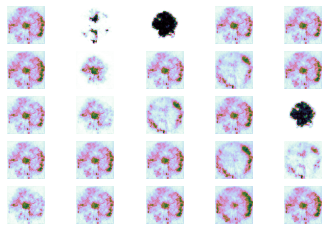

12201 [D loss: 0.391100, acc.: 82.81%] [G loss: 27.107658]
12202 [D loss: 1.050193, acc.: 70.70%] [G loss: 18.357801]
12203 [D loss: 0.023552, acc.: 99.22%] [G loss: 12.027745]
12204 [D loss: 0.076060, acc.: 94.14%] [G loss: 9.145027]
12205 [D loss: 0.014784, acc.: 100.00%] [G loss: 6.313979]
12206 [D loss: 0.185922, acc.: 96.48%] [G loss: 13.066267]
12207 [D loss: 0.151583, acc.: 94.53%] [G loss: 13.773952]
12208 [D loss: 0.223545, acc.: 91.80%] [G loss: 5.586850]
12209 [D loss: 0.177824, acc.: 92.97%] [G loss: 10.528164]
12210 [D loss: 0.116023, acc.: 93.75%] [G loss: 9.798107]
12211 [D loss: 0.076952, acc.: 97.66%] [G loss: 5.563715]
12212 [D loss: 0.074783, acc.: 100.00%] [G loss: 8.563635]
12213 [D loss: 0.086502, acc.: 96.88%] [G loss: 7.738464]
12214 [D loss: 0.089421, acc.: 95.31%] [G loss: 7.548753]
12215 [D loss: 0.042640, acc.: 98.83%] [G loss: 6.159838]
12216 [D loss: 0.079410, acc.: 98.83%] [G loss: 7.032134]
12217 [D loss: 0.027123, acc.: 99.61%] [G loss: 6.131308]
12218 

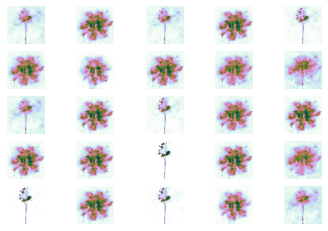

12401 [D loss: 0.009548, acc.: 100.00%] [G loss: 5.684441]
12402 [D loss: 0.032924, acc.: 99.61%] [G loss: 6.185146]
12403 [D loss: 0.013357, acc.: 100.00%] [G loss: 6.322934]
12404 [D loss: 0.009354, acc.: 100.00%] [G loss: 5.955127]
12405 [D loss: 0.044300, acc.: 99.61%] [G loss: 6.026268]
12406 [D loss: 0.004945, acc.: 100.00%] [G loss: 6.808658]
12407 [D loss: 0.052894, acc.: 98.44%] [G loss: 5.515586]
12408 [D loss: 0.015501, acc.: 100.00%] [G loss: 6.270884]
12409 [D loss: 0.017869, acc.: 99.22%] [G loss: 6.302189]
12410 [D loss: 0.036638, acc.: 99.61%] [G loss: 6.409916]
12411 [D loss: 0.007924, acc.: 100.00%] [G loss: 6.046524]
12412 [D loss: 0.040207, acc.: 99.61%] [G loss: 5.664647]
12413 [D loss: 0.010275, acc.: 100.00%] [G loss: 5.929232]
12414 [D loss: 0.014681, acc.: 100.00%] [G loss: 5.769550]
12415 [D loss: 0.050870, acc.: 99.22%] [G loss: 5.970973]
12416 [D loss: 0.032993, acc.: 99.61%] [G loss: 5.958753]
12417 [D loss: 0.021602, acc.: 100.00%] [G loss: 5.701937]
12418

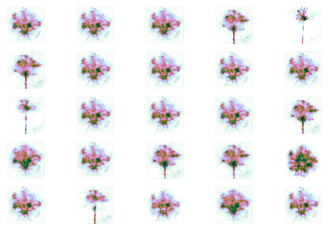

12601 [D loss: 0.045430, acc.: 98.83%] [G loss: 6.358198]
12602 [D loss: 0.018825, acc.: 99.61%] [G loss: 6.331864]
12603 [D loss: 0.019827, acc.: 100.00%] [G loss: 5.978305]
12604 [D loss: 0.046129, acc.: 99.61%] [G loss: 5.691906]
12605 [D loss: 0.010945, acc.: 100.00%] [G loss: 5.904972]
12606 [D loss: 0.097845, acc.: 97.27%] [G loss: 7.844536]
12607 [D loss: 0.044369, acc.: 99.22%] [G loss: 7.990215]
12608 [D loss: 0.321394, acc.: 95.31%] [G loss: 19.670017]
12609 [D loss: 0.157866, acc.: 94.53%] [G loss: 18.651814]
12610 [D loss: 0.079914, acc.: 95.70%] [G loss: 14.806490]
12611 [D loss: 0.127495, acc.: 98.05%] [G loss: 9.416294]
12612 [D loss: 0.101396, acc.: 97.66%] [G loss: 7.589939]
12613 [D loss: 0.027460, acc.: 99.61%] [G loss: 7.161738]
12614 [D loss: 0.353884, acc.: 91.41%] [G loss: 16.129553]
12615 [D loss: 0.285636, acc.: 91.41%] [G loss: 12.824753]
12616 [D loss: 0.105257, acc.: 97.66%] [G loss: 9.138966]
12617 [D loss: 0.045709, acc.: 99.22%] [G loss: 7.395175]
12618 [

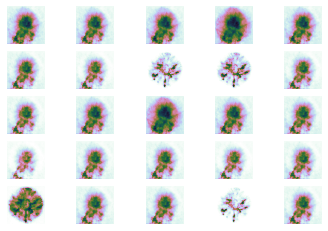

12801 [D loss: 0.228941, acc.: 89.84%] [G loss: 14.163790]
12802 [D loss: 0.050970, acc.: 98.44%] [G loss: 12.886488]
12803 [D loss: 0.081331, acc.: 96.88%] [G loss: 7.188359]
12804 [D loss: 0.183995, acc.: 97.27%] [G loss: 12.857480]
12805 [D loss: 0.072549, acc.: 97.27%] [G loss: 11.673000]
12806 [D loss: 0.135470, acc.: 96.09%] [G loss: 10.329346]
12807 [D loss: 0.207571, acc.: 92.58%] [G loss: 5.875171]
12808 [D loss: 0.211781, acc.: 92.97%] [G loss: 10.164715]
12809 [D loss: 0.626518, acc.: 89.84%] [G loss: 5.833954]
12810 [D loss: 0.351492, acc.: 90.62%] [G loss: 10.078010]
12811 [D loss: 0.028228, acc.: 98.83%] [G loss: 11.495201]
12812 [D loss: 0.274515, acc.: 95.31%] [G loss: 7.126863]
12813 [D loss: 0.038002, acc.: 98.83%] [G loss: 8.018904]
12814 [D loss: 0.027442, acc.: 99.22%] [G loss: 7.138872]
12815 [D loss: 0.039486, acc.: 99.61%] [G loss: 7.684293]
12816 [D loss: 0.054898, acc.: 97.66%] [G loss: 7.086927]
12817 [D loss: 0.099633, acc.: 95.31%] [G loss: 7.786474]
12818 

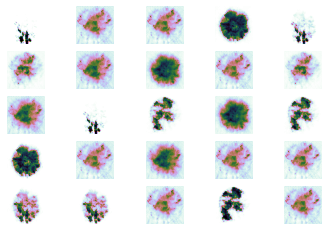

13001 [D loss: 0.072686, acc.: 96.09%] [G loss: 8.062135]
13002 [D loss: 0.070317, acc.: 97.66%] [G loss: 9.179714]
13003 [D loss: 0.032239, acc.: 100.00%] [G loss: 8.579719]
13004 [D loss: 0.043281, acc.: 98.83%] [G loss: 6.985661]
13005 [D loss: 0.026046, acc.: 100.00%] [G loss: 7.562565]
13006 [D loss: 0.042000, acc.: 98.83%] [G loss: 8.819545]
13007 [D loss: 0.135223, acc.: 95.70%] [G loss: 7.054893]
13008 [D loss: 0.120332, acc.: 95.70%] [G loss: 11.917330]
13009 [D loss: 0.140147, acc.: 94.53%] [G loss: 8.195705]
13010 [D loss: 0.033313, acc.: 99.61%] [G loss: 7.176636]
13011 [D loss: 0.008444, acc.: 100.00%] [G loss: 6.257374]
13012 [D loss: 0.031563, acc.: 99.61%] [G loss: 6.864722]
13013 [D loss: 0.023128, acc.: 99.61%] [G loss: 6.096434]
13014 [D loss: 0.048797, acc.: 99.61%] [G loss: 7.608424]
13015 [D loss: 0.071959, acc.: 98.05%] [G loss: 5.486926]
13016 [D loss: 0.034525, acc.: 99.61%] [G loss: 6.706147]
13017 [D loss: 0.048283, acc.: 98.05%] [G loss: 5.808113]
13018 [D l

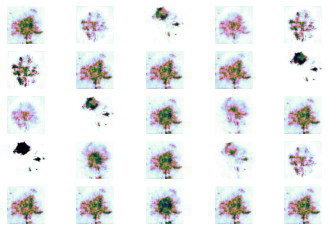

13201 [D loss: 0.042353, acc.: 98.83%] [G loss: 9.335234]
13202 [D loss: 0.007292, acc.: 100.00%] [G loss: 8.405975]
13203 [D loss: 0.037282, acc.: 99.61%] [G loss: 7.927271]
13204 [D loss: 0.008512, acc.: 100.00%] [G loss: 7.520732]
13205 [D loss: 0.037119, acc.: 99.22%] [G loss: 6.714400]
13206 [D loss: 0.009361, acc.: 100.00%] [G loss: 6.154987]
13207 [D loss: 0.076039, acc.: 98.44%] [G loss: 9.945568]
13208 [D loss: 0.039969, acc.: 98.83%] [G loss: 10.446590]
13209 [D loss: 0.038069, acc.: 98.44%] [G loss: 7.675703]
13210 [D loss: 0.010765, acc.: 100.00%] [G loss: 7.210804]
13211 [D loss: 0.012210, acc.: 99.61%] [G loss: 5.881443]
13212 [D loss: 0.035513, acc.: 99.61%] [G loss: 8.709591]
13213 [D loss: 0.006789, acc.: 100.00%] [G loss: 10.265551]
13214 [D loss: 0.036967, acc.: 99.61%] [G loss: 7.303458]
13215 [D loss: 0.018192, acc.: 99.61%] [G loss: 6.258721]
13216 [D loss: 0.021901, acc.: 100.00%] [G loss: 7.873391]
13217 [D loss: 0.017710, acc.: 99.61%] [G loss: 7.163324]
13218 

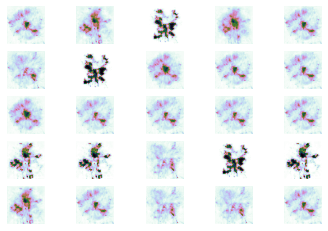

13401 [D loss: 0.032144, acc.: 99.61%] [G loss: 7.347463]
13402 [D loss: 0.022657, acc.: 100.00%] [G loss: 7.107692]
13403 [D loss: 0.014120, acc.: 99.61%] [G loss: 6.401957]
13404 [D loss: 0.013921, acc.: 99.61%] [G loss: 6.116889]
13405 [D loss: 0.135421, acc.: 94.14%] [G loss: 15.720669]
13406 [D loss: 0.724787, acc.: 75.00%] [G loss: 24.465342]
13407 [D loss: 0.548780, acc.: 78.91%] [G loss: 10.651178]
13408 [D loss: 0.024871, acc.: 100.00%] [G loss: 5.797404]
13409 [D loss: 0.243834, acc.: 81.25%] [G loss: 13.162235]
13410 [D loss: 0.022839, acc.: 99.61%] [G loss: 17.835165]
13411 [D loss: 0.313740, acc.: 90.23%] [G loss: 8.314419]
13412 [D loss: 0.110891, acc.: 96.09%] [G loss: 8.077743]
13413 [D loss: 0.011470, acc.: 100.00%] [G loss: 9.134136]
13414 [D loss: 0.024826, acc.: 98.44%] [G loss: 7.456090]
13415 [D loss: 0.036350, acc.: 100.00%] [G loss: 7.340263]
13416 [D loss: 0.034221, acc.: 99.22%] [G loss: 6.623687]
13417 [D loss: 0.020359, acc.: 99.61%] [G loss: 5.942041]
13418

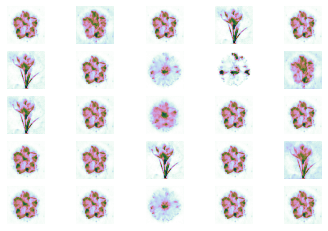

13601 [D loss: 0.007258, acc.: 100.00%] [G loss: 6.028646]
13602 [D loss: 0.008708, acc.: 100.00%] [G loss: 5.878562]
13603 [D loss: 0.028885, acc.: 99.61%] [G loss: 6.237080]
13604 [D loss: 0.005636, acc.: 100.00%] [G loss: 6.092755]
13605 [D loss: 0.053997, acc.: 99.22%] [G loss: 5.915566]
13606 [D loss: 0.005389, acc.: 100.00%] [G loss: 6.300532]
13607 [D loss: 0.006738, acc.: 100.00%] [G loss: 6.119397]
13608 [D loss: 0.006474, acc.: 100.00%] [G loss: 6.003193]
13609 [D loss: 0.006397, acc.: 100.00%] [G loss: 6.362525]
13610 [D loss: 0.005925, acc.: 100.00%] [G loss: 6.628540]
13611 [D loss: 0.003467, acc.: 100.00%] [G loss: 6.964405]
13612 [D loss: 0.038402, acc.: 99.61%] [G loss: 6.054742]
13613 [D loss: 0.087709, acc.: 99.22%] [G loss: 6.982759]
13614 [D loss: 0.032069, acc.: 99.61%] [G loss: 7.120417]
13615 [D loss: 0.061312, acc.: 99.22%] [G loss: 5.526005]
13616 [D loss: 0.033242, acc.: 99.61%] [G loss: 7.301670]
13617 [D loss: 0.002862, acc.: 100.00%] [G loss: 9.036198]
1361

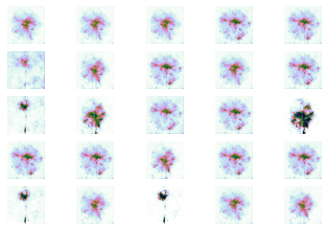

13801 [D loss: 0.048482, acc.: 99.61%] [G loss: 6.205538]
13802 [D loss: 0.020054, acc.: 100.00%] [G loss: 5.596985]
13803 [D loss: 0.067737, acc.: 98.83%] [G loss: 5.798082]
13804 [D loss: 0.030113, acc.: 99.61%] [G loss: 6.423650]
13805 [D loss: 0.029140, acc.: 99.61%] [G loss: 5.671947]
13806 [D loss: 0.030750, acc.: 100.00%] [G loss: 5.988074]
13807 [D loss: 0.030052, acc.: 98.83%] [G loss: 5.858363]
13808 [D loss: 0.027294, acc.: 100.00%] [G loss: 6.466997]
13809 [D loss: 0.051825, acc.: 98.44%] [G loss: 5.703614]
13810 [D loss: 0.022597, acc.: 100.00%] [G loss: 6.177798]
13811 [D loss: 0.107834, acc.: 94.14%] [G loss: 8.487524]
13812 [D loss: 0.097899, acc.: 96.09%] [G loss: 7.287093]
13813 [D loss: 0.050374, acc.: 98.44%] [G loss: 6.331076]
13814 [D loss: 0.032620, acc.: 99.22%] [G loss: 6.618384]
13815 [D loss: 0.014351, acc.: 99.61%] [G loss: 6.138117]
13816 [D loss: 0.012414, acc.: 100.00%] [G loss: 6.667298]
13817 [D loss: 0.043248, acc.: 99.22%] [G loss: 5.597406]
13818 [D 

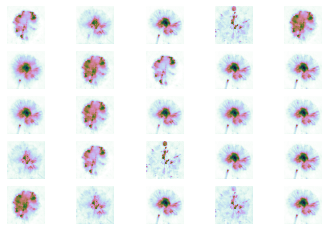

14001 [D loss: 0.009249, acc.: 100.00%] [G loss: 5.795800]
14002 [D loss: 0.007477, acc.: 100.00%] [G loss: 5.770717]
14003 [D loss: 0.044413, acc.: 99.61%] [G loss: 5.258981]
14004 [D loss: 0.046194, acc.: 99.61%] [G loss: 5.742180]
14005 [D loss: 0.005170, acc.: 100.00%] [G loss: 6.563245]
14006 [D loss: 0.041787, acc.: 99.61%] [G loss: 5.288506]
14007 [D loss: 0.030089, acc.: 99.61%] [G loss: 5.473900]
14008 [D loss: 0.007800, acc.: 100.00%] [G loss: 6.213194]
14009 [D loss: 0.006860, acc.: 100.00%] [G loss: 6.366616]
14010 [D loss: 0.027247, acc.: 99.61%] [G loss: 5.621347]
14011 [D loss: 0.019349, acc.: 99.61%] [G loss: 5.348763]
14012 [D loss: 0.007597, acc.: 100.00%] [G loss: 5.742044]
14013 [D loss: 0.019307, acc.: 99.61%] [G loss: 5.464055]
14014 [D loss: 0.046598, acc.: 99.61%] [G loss: 5.410519]
14015 [D loss: 0.006989, acc.: 100.00%] [G loss: 6.409451]
14016 [D loss: 0.005085, acc.: 100.00%] [G loss: 6.520113]
14017 [D loss: 0.009955, acc.: 100.00%] [G loss: 5.688788]
14018

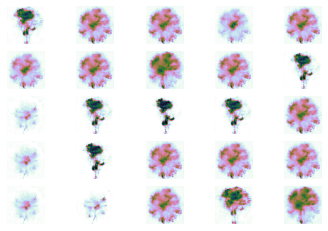

14201 [D loss: 0.009551, acc.: 100.00%] [G loss: 7.150243]
14202 [D loss: 0.015075, acc.: 99.61%] [G loss: 6.124838]
14203 [D loss: 0.043601, acc.: 99.61%] [G loss: 8.345056]
14204 [D loss: 0.021388, acc.: 99.22%] [G loss: 7.549261]
14205 [D loss: 0.020485, acc.: 99.61%] [G loss: 6.053753]
14206 [D loss: 0.012725, acc.: 100.00%] [G loss: 6.391243]
14207 [D loss: 0.009849, acc.: 100.00%] [G loss: 6.452127]
14208 [D loss: 0.046710, acc.: 98.83%] [G loss: 6.064396]
14209 [D loss: 0.036166, acc.: 99.22%] [G loss: 6.109653]
14210 [D loss: 0.027122, acc.: 99.61%] [G loss: 6.497566]
14211 [D loss: 0.011506, acc.: 100.00%] [G loss: 6.234721]
14212 [D loss: 0.019667, acc.: 99.61%] [G loss: 6.212111]
14213 [D loss: 0.023167, acc.: 99.61%] [G loss: 6.707465]
14214 [D loss: 0.015339, acc.: 99.61%] [G loss: 6.268780]
14215 [D loss: 0.017554, acc.: 100.00%] [G loss: 7.370264]
14216 [D loss: 0.016950, acc.: 99.61%] [G loss: 6.917459]
14217 [D loss: 0.019062, acc.: 100.00%] [G loss: 7.032595]
14218 [D

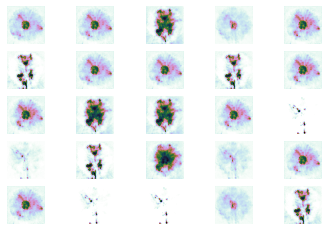

14401 [D loss: 0.027643, acc.: 99.61%] [G loss: 5.880289]
14402 [D loss: 0.016307, acc.: 100.00%] [G loss: 6.134888]
14403 [D loss: 0.041836, acc.: 99.61%] [G loss: 6.677995]
14404 [D loss: 0.032341, acc.: 99.61%] [G loss: 6.031589]
14405 [D loss: 0.047198, acc.: 99.22%] [G loss: 6.919452]
14406 [D loss: 0.052818, acc.: 99.22%] [G loss: 5.894676]
14407 [D loss: 0.045984, acc.: 99.61%] [G loss: 7.364617]
14408 [D loss: 0.019277, acc.: 99.61%] [G loss: 7.142051]
14409 [D loss: 0.046305, acc.: 99.22%] [G loss: 6.770274]
14410 [D loss: 0.024865, acc.: 99.61%] [G loss: 8.423100]
14411 [D loss: 0.034901, acc.: 98.83%] [G loss: 6.371576]
14412 [D loss: 0.041102, acc.: 99.61%] [G loss: 7.542802]
14413 [D loss: 0.015365, acc.: 99.61%] [G loss: 7.786359]
14414 [D loss: 0.087410, acc.: 96.09%] [G loss: 12.159010]
14415 [D loss: 0.069908, acc.: 99.22%] [G loss: 13.528385]
14416 [D loss: 0.138175, acc.: 96.88%] [G loss: 12.219473]
14417 [D loss: 0.031439, acc.: 99.22%] [G loss: 10.765789]
14418 [D 

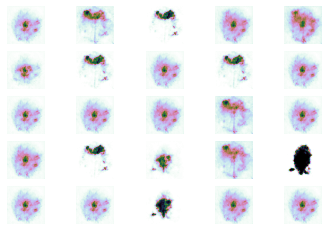

14601 [D loss: 0.021481, acc.: 99.61%] [G loss: 5.635387]
14602 [D loss: 0.136846, acc.: 96.88%] [G loss: 6.566317]
14603 [D loss: 0.101547, acc.: 96.09%] [G loss: 6.628383]
14604 [D loss: 0.073670, acc.: 98.44%] [G loss: 6.255551]
14605 [D loss: 0.073573, acc.: 99.22%] [G loss: 9.593127]
14606 [D loss: 0.090544, acc.: 97.27%] [G loss: 8.043163]
14607 [D loss: 0.074423, acc.: 98.83%] [G loss: 8.340024]
14608 [D loss: 0.031760, acc.: 98.83%] [G loss: 6.443140]
14609 [D loss: 0.115680, acc.: 93.36%] [G loss: 12.116879]
14610 [D loss: 0.095470, acc.: 96.09%] [G loss: 10.678773]
14611 [D loss: 0.097839, acc.: 98.44%] [G loss: 11.785965]
14612 [D loss: 0.075306, acc.: 98.44%] [G loss: 9.459098]
14613 [D loss: 0.043167, acc.: 99.61%] [G loss: 6.381482]
14614 [D loss: 0.034773, acc.: 99.22%] [G loss: 5.555855]
14615 [D loss: 0.014448, acc.: 100.00%] [G loss: 5.972319]
14616 [D loss: 0.028553, acc.: 99.61%] [G loss: 5.996091]
14617 [D loss: 0.035109, acc.: 99.22%] [G loss: 5.297581]
14618 [D l

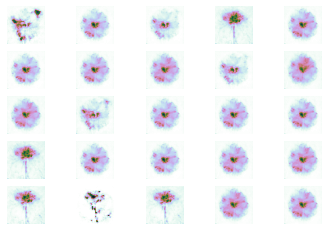

14801 [D loss: 0.030196, acc.: 99.61%] [G loss: 6.149462]
14802 [D loss: 0.064189, acc.: 98.44%] [G loss: 6.725902]
14803 [D loss: 0.007331, acc.: 100.00%] [G loss: 6.938732]
14804 [D loss: 0.013185, acc.: 100.00%] [G loss: 6.245056]
14805 [D loss: 0.032706, acc.: 99.61%] [G loss: 5.581560]
14806 [D loss: 0.045670, acc.: 98.05%] [G loss: 6.843208]
14807 [D loss: 0.045511, acc.: 99.22%] [G loss: 5.477097]
14808 [D loss: 0.015332, acc.: 100.00%] [G loss: 6.166884]
14809 [D loss: 0.009444, acc.: 100.00%] [G loss: 6.407405]
14810 [D loss: 0.125605, acc.: 94.92%] [G loss: 8.443350]
14811 [D loss: 0.070055, acc.: 97.27%] [G loss: 6.541296]
14812 [D loss: 0.045095, acc.: 99.22%] [G loss: 7.376232]
14813 [D loss: 0.015034, acc.: 99.22%] [G loss: 7.366025]
14814 [D loss: 0.015678, acc.: 99.61%] [G loss: 5.831792]
14815 [D loss: 0.029014, acc.: 99.61%] [G loss: 7.157095]
14816 [D loss: 0.027576, acc.: 99.22%] [G loss: 6.783411]
14817 [D loss: 0.042240, acc.: 99.61%] [G loss: 6.376385]
14818 [D l

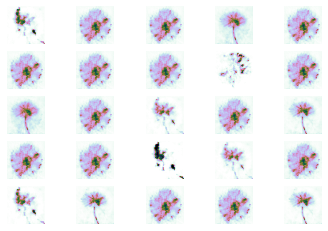

15001 [D loss: 0.008699, acc.: 100.00%] [G loss: 6.645061]
15002 [D loss: 0.012286, acc.: 100.00%] [G loss: 6.713659]
15003 [D loss: 0.072909, acc.: 98.83%] [G loss: 7.120249]
15004 [D loss: 0.020512, acc.: 99.61%] [G loss: 7.336718]
15005 [D loss: 0.033491, acc.: 99.61%] [G loss: 6.928104]
15006 [D loss: 0.062008, acc.: 98.83%] [G loss: 8.892186]
15007 [D loss: 0.022892, acc.: 99.61%] [G loss: 8.897203]
15008 [D loss: 0.028550, acc.: 99.61%] [G loss: 7.320103]
15009 [D loss: 0.013659, acc.: 100.00%] [G loss: 6.656087]
15010 [D loss: 0.006379, acc.: 100.00%] [G loss: 6.716737]
15011 [D loss: 0.005838, acc.: 100.00%] [G loss: 6.734101]
15012 [D loss: 0.013619, acc.: 99.61%] [G loss: 6.731611]
15013 [D loss: 0.035577, acc.: 99.22%] [G loss: 6.627030]
15014 [D loss: 0.004957, acc.: 100.00%] [G loss: 7.306147]
15015 [D loss: 0.010368, acc.: 100.00%] [G loss: 6.424611]
15016 [D loss: 0.012769, acc.: 100.00%] [G loss: 6.663696]
15017 [D loss: 0.024639, acc.: 99.61%] [G loss: 6.585010]
15018 

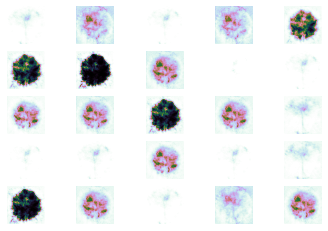

15201 [D loss: 2.389595, acc.: 78.52%] [G loss: 18.272335]
15202 [D loss: 0.870222, acc.: 69.53%] [G loss: 18.849054]
15203 [D loss: 0.506154, acc.: 90.62%] [G loss: 16.539726]
15204 [D loss: 0.048698, acc.: 98.05%] [G loss: 10.290773]
15205 [D loss: 0.413660, acc.: 92.58%] [G loss: 9.713878]
15206 [D loss: 0.057268, acc.: 97.66%] [G loss: 9.298800]
15207 [D loss: 0.268496, acc.: 89.84%] [G loss: 13.933754]
15208 [D loss: 0.265472, acc.: 93.75%] [G loss: 14.739776]
15209 [D loss: 0.106563, acc.: 94.92%] [G loss: 7.899990]
15210 [D loss: 0.903227, acc.: 72.66%] [G loss: 25.977337]
15211 [D loss: 0.580522, acc.: 83.59%] [G loss: 24.928400]
15212 [D loss: 0.279572, acc.: 89.06%] [G loss: 16.658169]
15213 [D loss: 0.411412, acc.: 95.31%] [G loss: 12.056385]
15214 [D loss: 0.220051, acc.: 93.36%] [G loss: 11.042482]
15215 [D loss: 0.228838, acc.: 94.14%] [G loss: 7.641908]
15216 [D loss: 0.131573, acc.: 95.70%] [G loss: 10.303448]
15217 [D loss: 0.163042, acc.: 94.92%] [G loss: 7.471437]
15

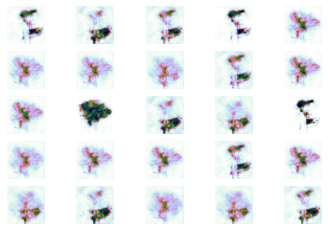

15401 [D loss: 0.100599, acc.: 98.05%] [G loss: 6.564900]
15402 [D loss: 0.024771, acc.: 99.22%] [G loss: 6.671456]
15403 [D loss: 0.044403, acc.: 99.61%] [G loss: 5.277840]
15404 [D loss: 0.018576, acc.: 100.00%] [G loss: 5.939959]
15405 [D loss: 0.046496, acc.: 99.61%] [G loss: 6.349095]
15406 [D loss: 0.031729, acc.: 99.22%] [G loss: 5.733058]
15407 [D loss: 0.034358, acc.: 98.44%] [G loss: 6.668666]
15408 [D loss: 0.075135, acc.: 98.44%] [G loss: 6.390535]
15409 [D loss: 0.029871, acc.: 99.22%] [G loss: 5.527494]
15410 [D loss: 0.027038, acc.: 99.61%] [G loss: 6.260279]
15411 [D loss: 0.022595, acc.: 100.00%] [G loss: 6.653531]
15412 [D loss: 0.035783, acc.: 99.61%] [G loss: 6.209419]
15413 [D loss: 0.029413, acc.: 99.61%] [G loss: 5.675101]
15414 [D loss: 0.023576, acc.: 100.00%] [G loss: 6.659372]
15415 [D loss: 0.051102, acc.: 98.83%] [G loss: 6.725587]
15416 [D loss: 0.026145, acc.: 99.61%] [G loss: 6.611754]
15417 [D loss: 0.019289, acc.: 100.00%] [G loss: 6.103536]
15418 [D l

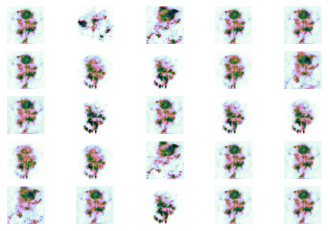

15601 [D loss: 0.029380, acc.: 97.66%] [G loss: 9.575030]
15602 [D loss: 0.005225, acc.: 100.00%] [G loss: 8.407834]
15603 [D loss: 0.021862, acc.: 99.61%] [G loss: 7.323975]
15604 [D loss: 0.012958, acc.: 100.00%] [G loss: 7.892704]
15605 [D loss: 0.012901, acc.: 100.00%] [G loss: 7.565357]
15606 [D loss: 0.054404, acc.: 99.61%] [G loss: 6.147124]
15607 [D loss: 0.034866, acc.: 100.00%] [G loss: 8.649080]
15608 [D loss: 0.025701, acc.: 99.61%] [G loss: 8.417730]
15609 [D loss: 0.009597, acc.: 100.00%] [G loss: 6.411822]
15610 [D loss: 0.015116, acc.: 100.00%] [G loss: 6.784582]
15611 [D loss: 0.013909, acc.: 100.00%] [G loss: 6.666349]
15612 [D loss: 0.014661, acc.: 100.00%] [G loss: 6.260488]
15613 [D loss: 0.037902, acc.: 100.00%] [G loss: 9.184742]
15614 [D loss: 0.063211, acc.: 98.83%] [G loss: 8.243563]
15615 [D loss: 0.020200, acc.: 99.22%] [G loss: 6.877646]
15616 [D loss: 0.014008, acc.: 99.61%] [G loss: 6.609450]
15617 [D loss: 0.018290, acc.: 100.00%] [G loss: 6.566560]
1561

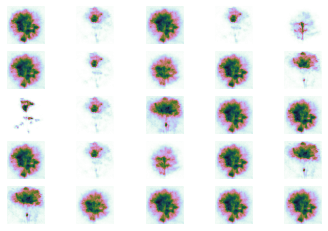

15801 [D loss: 0.072094, acc.: 98.83%] [G loss: 16.150831]
15802 [D loss: 0.096084, acc.: 94.53%] [G loss: 10.657306]
15803 [D loss: 0.045305, acc.: 98.83%] [G loss: 6.504791]
15804 [D loss: 0.085930, acc.: 98.83%] [G loss: 9.988957]
15805 [D loss: 0.093496, acc.: 96.48%] [G loss: 8.638700]
15806 [D loss: 0.049693, acc.: 98.83%] [G loss: 5.735002]
15807 [D loss: 0.113064, acc.: 97.66%] [G loss: 14.363192]
15808 [D loss: 0.145049, acc.: 93.36%] [G loss: 10.743587]
15809 [D loss: 0.082377, acc.: 96.09%] [G loss: 9.723506]
15810 [D loss: 0.061286, acc.: 98.44%] [G loss: 8.011590]
15811 [D loss: 0.269380, acc.: 83.98%] [G loss: 27.598646]
15812 [D loss: 2.064595, acc.: 62.11%] [G loss: 13.728368]
15813 [D loss: 0.027393, acc.: 99.22%] [G loss: 11.855476]
15814 [D loss: 0.010969, acc.: 99.61%] [G loss: 7.901610]
15815 [D loss: 0.127074, acc.: 95.31%] [G loss: 10.051818]
15816 [D loss: 0.146583, acc.: 94.53%] [G loss: 11.031961]
15817 [D loss: 0.256829, acc.: 94.14%] [G loss: 6.514421]
15818

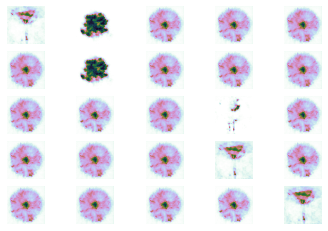

16001 [D loss: 0.018951, acc.: 100.00%] [G loss: 6.911922]
16002 [D loss: 0.121504, acc.: 98.44%] [G loss: 11.928399]
16003 [D loss: 0.112393, acc.: 95.70%] [G loss: 9.184358]
16004 [D loss: 0.010052, acc.: 100.00%] [G loss: 6.873407]
16005 [D loss: 0.010008, acc.: 100.00%] [G loss: 6.228675]
16006 [D loss: 0.011167, acc.: 100.00%] [G loss: 6.339624]
16007 [D loss: 0.020848, acc.: 99.61%] [G loss: 6.549516]
16008 [D loss: 0.015063, acc.: 99.61%] [G loss: 6.025046]
16009 [D loss: 0.013697, acc.: 100.00%] [G loss: 6.353097]
16010 [D loss: 0.070928, acc.: 98.83%] [G loss: 6.709335]
16011 [D loss: 0.011774, acc.: 100.00%] [G loss: 7.250013]
16012 [D loss: 0.040115, acc.: 98.83%] [G loss: 6.465127]
16013 [D loss: 0.006903, acc.: 100.00%] [G loss: 7.291021]
16014 [D loss: 0.021686, acc.: 99.22%] [G loss: 6.456768]
16015 [D loss: 0.079110, acc.: 99.61%] [G loss: 8.511347]
16016 [D loss: 0.015405, acc.: 100.00%] [G loss: 9.729739]
16017 [D loss: 0.026948, acc.: 99.61%] [G loss: 6.166586]
16018

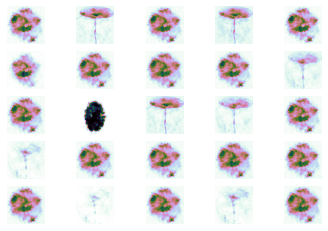

16201 [D loss: 0.040657, acc.: 99.61%] [G loss: 6.262768]
16202 [D loss: 0.023434, acc.: 99.61%] [G loss: 6.669537]
16203 [D loss: 0.014248, acc.: 99.61%] [G loss: 7.164109]
16204 [D loss: 0.013714, acc.: 100.00%] [G loss: 6.316713]
16205 [D loss: 0.029446, acc.: 99.61%] [G loss: 7.021166]
16206 [D loss: 0.010487, acc.: 100.00%] [G loss: 6.762484]
16207 [D loss: 0.029587, acc.: 100.00%] [G loss: 6.836716]
16208 [D loss: 0.048930, acc.: 99.61%] [G loss: 6.803978]
16209 [D loss: 0.065696, acc.: 98.83%] [G loss: 8.065791]
16210 [D loss: 0.014973, acc.: 99.61%] [G loss: 9.869707]
16211 [D loss: 0.005144, acc.: 100.00%] [G loss: 7.392274]
16212 [D loss: 0.009679, acc.: 100.00%] [G loss: 6.726507]
16213 [D loss: 0.024172, acc.: 99.61%] [G loss: 7.611698]
16214 [D loss: 0.039224, acc.: 99.61%] [G loss: 6.691036]
16215 [D loss: 0.014056, acc.: 100.00%] [G loss: 6.407464]
16216 [D loss: 0.022746, acc.: 99.22%] [G loss: 6.536138]
16217 [D loss: 0.031957, acc.: 99.22%] [G loss: 8.364779]
16218 [D

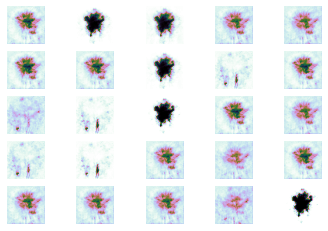

16401 [D loss: 0.193107, acc.: 94.14%] [G loss: 18.962618]
16402 [D loss: 0.213647, acc.: 91.80%] [G loss: 19.564165]
16403 [D loss: 0.102106, acc.: 94.53%] [G loss: 12.705006]
16404 [D loss: 0.021380, acc.: 99.22%] [G loss: 9.084311]
16405 [D loss: 0.031990, acc.: 100.00%] [G loss: 8.141283]
16406 [D loss: 0.019728, acc.: 99.61%] [G loss: 7.812000]
16407 [D loss: 0.024305, acc.: 100.00%] [G loss: 7.988807]
16408 [D loss: 0.012965, acc.: 99.61%] [G loss: 6.656812]
16409 [D loss: 0.222116, acc.: 96.88%] [G loss: 17.754625]
16410 [D loss: 0.159068, acc.: 94.14%] [G loss: 19.166912]
16411 [D loss: 0.076594, acc.: 95.31%] [G loss: 16.267935]
16412 [D loss: 0.054292, acc.: 97.27%] [G loss: 16.341768]
16413 [D loss: 0.088142, acc.: 97.27%] [G loss: 12.906116]
16414 [D loss: 0.008152, acc.: 99.61%] [G loss: 9.550720]
16415 [D loss: 0.088946, acc.: 94.92%] [G loss: 8.383334]
16416 [D loss: 0.018351, acc.: 100.00%] [G loss: 8.192041]
16417 [D loss: 0.089961, acc.: 96.88%] [G loss: 11.050627]
16

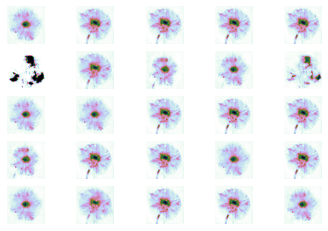

16601 [D loss: 0.012922, acc.: 100.00%] [G loss: 6.438445]
16602 [D loss: 0.009476, acc.: 100.00%] [G loss: 6.689055]
16603 [D loss: 0.015682, acc.: 100.00%] [G loss: 5.776224]
16604 [D loss: 0.011667, acc.: 100.00%] [G loss: 5.933735]
16605 [D loss: 0.009627, acc.: 100.00%] [G loss: 6.268564]
16606 [D loss: 0.028394, acc.: 99.61%] [G loss: 5.678115]
16607 [D loss: 0.013581, acc.: 100.00%] [G loss: 6.342236]
16608 [D loss: 0.043186, acc.: 99.61%] [G loss: 6.168360]
16609 [D loss: 0.008064, acc.: 100.00%] [G loss: 6.150907]
16610 [D loss: 0.038668, acc.: 99.61%] [G loss: 5.869285]
16611 [D loss: 0.043496, acc.: 99.61%] [G loss: 6.246275]
16612 [D loss: 0.059771, acc.: 98.83%] [G loss: 5.956009]
16613 [D loss: 0.005339, acc.: 100.00%] [G loss: 6.848154]
16614 [D loss: 0.013052, acc.: 100.00%] [G loss: 6.472363]
16615 [D loss: 0.036067, acc.: 99.61%] [G loss: 5.962578]
16616 [D loss: 0.020147, acc.: 99.61%] [G loss: 5.466768]
16617 [D loss: 0.034276, acc.: 99.61%] [G loss: 6.065955]
16618

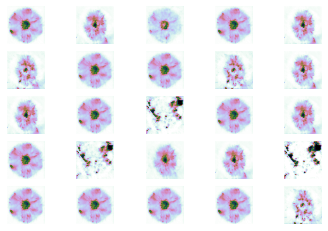

16801 [D loss: 0.015375, acc.: 100.00%] [G loss: 6.713603]
16802 [D loss: 0.007778, acc.: 100.00%] [G loss: 6.757184]
16803 [D loss: 0.031507, acc.: 99.61%] [G loss: 6.729642]
16804 [D loss: 0.030589, acc.: 100.00%] [G loss: 7.872322]
16805 [D loss: 0.011641, acc.: 100.00%] [G loss: 8.876644]
16806 [D loss: 0.028296, acc.: 99.61%] [G loss: 6.713090]
16807 [D loss: 0.009213, acc.: 100.00%] [G loss: 7.191184]
16808 [D loss: 0.018542, acc.: 99.61%] [G loss: 6.912771]
16809 [D loss: 0.015392, acc.: 99.61%] [G loss: 6.455368]
16810 [D loss: 0.009332, acc.: 100.00%] [G loss: 6.775262]
16811 [D loss: 0.068890, acc.: 99.22%] [G loss: 5.940448]
16812 [D loss: 0.052403, acc.: 99.61%] [G loss: 5.538466]
16813 [D loss: 0.042196, acc.: 99.22%] [G loss: 5.883985]
16814 [D loss: 0.009405, acc.: 99.61%] [G loss: 6.162023]
16815 [D loss: 0.052413, acc.: 99.22%] [G loss: 5.535410]
16816 [D loss: 0.044537, acc.: 99.61%] [G loss: 5.997816]
16817 [D loss: 0.025430, acc.: 99.22%] [G loss: 5.820790]
16818 [D

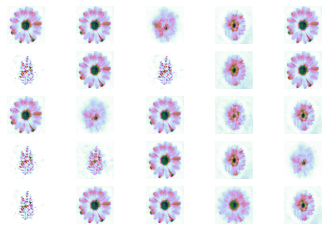

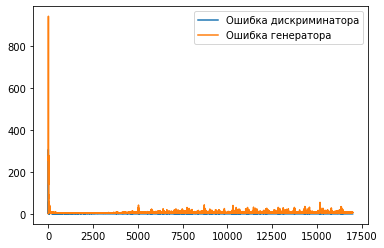

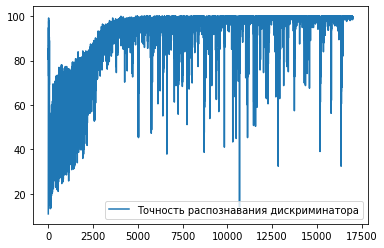

In [ ]:
generator = create_generator()
discriminator = create_conv_discriminator() 
train(generator, discriminator, 17000)

In [ ]:
gen.save_weights('drive/My Drive/generatorС.h5')
#gen.load_weights('drive/My Drive/generatorС.h5')

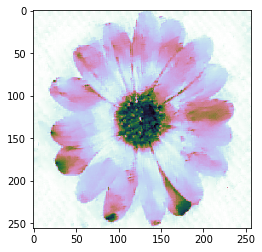

In [ ]:
input1 = np.random.random(size=(1, 100))
predict_gen = generator.predict(input1)
plt.imshow(predict_gen[0].reshape(256, 256), cmap='cubehelix')
plt.show()